In [1]:
import os
import numpy as np
import netCDF4 as nc4
import shutil
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt

In [2]:

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
import statsmodels.api as sm
from scipy import stats

### 1. Set control variables

In [4]:
doanalysis = 1
paramfileroot='/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/'
convgpp = 3600*24*1000 # KgC.m2/s to gc/m2/day
convet=3600*24

#where are we now?
read_params = 1
ncls_pft=5

USER='rfisher'
output_dir='/glade/derecho/scratch/'+USER+'/'
yr='.clm2.h0.'   

sgpath='sgmap.nc'

ppe_root='/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe'
pfts=[0, 1,2,10, 11] #removed the two shrub PFTs 


### Set ensemble specific control variables. 

In [5]:
ensN=16

if ensN == 1:
    spmode=1
    ncases=50
    ychoose =2000
    read_model_output=1
    ncls_param=4
    read_params = 1
    make_params=0
    pfileroot=ppe_root+'/nocomp_parameter_modification_python/paramfiles/SP_LHC/sp_lhc_v1_'  
    ens_directory='FATES_SP_LHC_ALLPFTS1_e_'   
    tf='-02.nc'


if ensN == 2:
    spmode=1
    ncases=50
    ychoose =1999
    read_model_output=1
    ncls_param=4
    read_params = 1
    make_params=0
    pfileroot=ppe_root+'/nocomp_parameter_modification_python/paramfiles/SP_LHC/sp_lhc_v2_'  
    ens_directory='FATES_SP_LHC_ALLPFTS2_e_'   
    tf='-02.nc'
    erasecatfile=1

if ensN == 16:
    spmode=0
    ncases=100
    ychoose= 19
    read_model_output=1
    ncls_param=4
    read_params = 1
    make_params=0
    pfileroot=ppe_root+'/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/nocomp_lhc_v16_'  
    ens_directory='FATES_NOCOMP_LHC16_ALLPFTS1_e_'   
    tf='-02.nc'
    erasecatfile=1
    pfts=[0]

if ensN == 15:
    spmode=0
    ncases=100
    ychoose= 19
    read_model_output=0
    ncls_param=4
    read_params = 1
    make_params=0
    pfileroot=ppe_root+'/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/nocomp_lhc_v15_'  
    ens_directory='FATES_NOCOMP_LHC15_ALLPFTS1_e_'   
    tf='-02.nc'
    erasecatfile=1

In [6]:
if(spmode==0):
    vars_bm=['ET','GPP','LAI','CUE','VEGC']
    vars_read=['FATES_GPP','FATES_NPP','FATES_LAI','FATES_NOCOMP_PATCHAREA_PF','QFLX_EVAP_TOT','FATES_VEGC','lat','lon']

else:
    vars_bm=['ET','GPP']
    vars_read=['FATES_GPP','FATES_LAI','QFLX_EVAP_TOT','lat','lon']

### Derived control variables

In [7]:
pdatafile='parameter_outputs/params_v'+str(ensN)+'.nc'

vs=range(1,ncases+1) 

if(ychoose<10):
    hstring='.clm2.h0.000'
elif (ychoose<100):
    hstring='.clm2.h0.00'
elif ychoose<1000:
    hstring='.clm2.h0.0' 
else:
    hstring='.clm2.h0.'
print('hstring',hstring)

pft_index=np.zeros(ncases*len(pfts))
print('pftindex',np.shape(pft_index))

hstring .clm2.h0.00
pftindex (100,)


In [8]:
def make_directory(fileroot):   
    if(os.path.isdir(fileroot)):
        print('dir exists:'+fileroot)
    else:
        os.mkdir(fileroot)
        print('made: '+fileroot)

In [9]:
figdir = (os.getcwd() +'/'+ 'figs_'+ens_directory+'/')
make_directory(figdir)

dir exists:/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_/


###  2. Make a single data structure for the ensemble

In [10]:
print(read_model_output)
if read_model_output==1:
    print(output_dir,ncases+1)
    caseroot=ens_directory
    vs=range(ncases)
    print('pfts',pfts)
    if doanalysis ==1:
        debug=0
        
        dsc_pft=[]
        firstgo=1
        count=0
        missing=np.multiply(range(0,ncases+1),0)
        for pft in pfts:
            print('pft',pft)
            for i in range(1,ncases+1):
                print(count,i)
                run=caseroot+str(i)+'_PFT_'+str(pft)
                print('run',run)
                pft_index[count]=pft
                count=count+1
                ahpath = output_dir + 'archive/' + run + '/lnd/hist/' 
                rhpath = output_dir + run + '/run/'                 
                tfile = run+hstring+str(ychoose)+tf
                tfile = run+hstring+str(ychoose)+'-02.nc' 
                tfileall= run+hstring+str(ychoose)+'-*.nc' 
                 
                missing[i]=1
                if(os.path.isfile(rhpath+tfile)):  # this years is in the archive. 
                    hpath = rhpath
                    if debug == 1 :print('file in rundir',rhpath)
                    missing[i]=0
                else:
                    if debug == 1 :print('file not in rundir. try archive')                
                    hpath = ahpath       
                    if(os.path.isdir(hpath)): 
                        #print('there is a rundir',hpath+tfile)                
                        if(os.path.isfile(hpath+tfile)):
                            if debug == 1 :print('file in  archive')
                            missing[i]=0
                        else:
                            print('no file in rundir',hpath+tfile)
                    else:
                        print('there is no  rundir',hpath+tfile)
                    
                if(missing[i]==0): # the year can be found. 
                    rt=hpath+run+yr+str(ychoose)+'*'
                    rt=hpath+tfileall
                    outf=hpath+'cat_file_'+str(i)+'_'+str(ychoose)+'.nc'
                    print('rt',rt)
                    if(os.path.isfile(outf)):
                        if(erasecatfile==1):                            
                            !rm $outf
                            !ncrcat --ovr $rt $outf
                        else:
                            print('already concatenated')
                    else:
                        !ncrcat --ovr $rt $outf
                    if debug==1: 
                        
                        print(rt)
                    if(firstgo==1):
                        tmp = xr.open_mfdataset(rt, decode_times=False)  
                        allvars=list(xr.open_dataset(hpath+tfile, decode_times=False).variables)
                        dropvars=list(set(allvars) - set(vars_read)) 
                        firstgo=0
                    #print('rt',rt)
                    tmp=xr.open_mfdataset(outf, decode_times=False, drop_variables=dropvars)
                else:
                    print('MISSING INPUT')
                  
                if i==1:
                    print('i=1')
                    try: 
                        del dsc
                    except:
                        print('no dsc')
                    dsc = tmp.load()           
                else:
                    dsc=xr.concat([dsc,tmp],'ens')
            dsc_pft.append(dsc)
    
    print('end')
else:
    print('not reading model output')

1
/glade/derecho/scratch/rfisher/ 101
pfts [0]
pft 0
0 1
run FATES_NOCOMP_LHC16_ALLPFTS1_e_1_PFT_0
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_LHC16_ALLPFTS1_e_1_PFT_0/lnd/hist/FATES_NOCOMP_LHC16_ALLPFTS1_e_1_PFT_0.clm2.h0.0019-*.nc
i=1
no dsc
1 2
run FATES_NOCOMP_LHC16_ALLPFTS1_e_2_PFT_0
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_LHC16_ALLPFTS1_e_2_PFT_0/lnd/hist/FATES_NOCOMP_LHC16_ALLPFTS1_e_2_PFT_0.clm2.h0.0019-*.nc
2 3
run FATES_NOCOMP_LHC16_ALLPFTS1_e_3_PFT_0
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_LHC16_ALLPFTS1_e_3_PFT_0/lnd/hist/FATES_NOCOMP_LHC16_ALLPFTS1_e_3_PFT_0.clm2.h0.0019-*.nc
3 4
run FATES_NOCOMP_LHC16_ALLPFTS1_e_4_PFT_0
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_LHC16_ALLPFTS1_e_4_PFT_0/lnd/hist/FATES_NOCOMP_LHC16_ALLPFTS1_e_4_PFT_0.clm2.h0.0019-*.nc
4 5
run FATES_NOCOMP_LHC16_ALLPFTS1_e_5_PFT_0
rt /glade/derecho/scratch/rfisher/archive/FATES_NOCOMP_LHC16_ALLPFTS1_e_5_PFT_0/lnd/hist/FATES_NOCOMP_LHC16_ALLPFTS1_e_5_PFT_0

### 3 Read parameter files into a list. 

In [11]:
if(read_params==1):
    vsp=range(1,ncases+1) 
    print(pfileroot)
    paramsp=['not found'] * 100
    if doanalysis ==1:
        # loop round whole ensemble
        for i in vsp: 
            pfile1= xr.open_dataset(pfileroot+str(i)+'.nc')  
            if i==vsp[0]:
                try: 
                    del dsc_params
                except:
                    print('no dsc')
                all_param_data = pfile1                      
            else:
                all_param_data=xr.concat([all_param_data, pfile1], "ens")  
                 # Close the file
            pfile1.close()
else:
    print('readging existing param file: ',pdatafile)
    all_param_data= xr.open_dataset(pdatafile) 
    

#### Write parameter output file

if(read_params==1):
    try:
        os.remove(pdatafile)
    except:
        print('no pfile')
        
    all_param_data.to_netcdf(pdatafile)  
 

/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/nocomp_parameter_modification_python/paramfiles/NOCOMP_LHC/nocomp_lhc_v16_
no dsc


#### 4. Find modified parameters

In [12]:
directory_path = pfileroot
data1= xr.open_dataset(pfileroot+str(1)+'.nc') 
data2= xr.open_dataset(pfileroot+str(2)+'.nc') 
common_variables = set(data1.variables) & set(data2.variables)

# Iterate through the common variables and compare their values
parlist=[]
for var_name in common_variables:
    var_data1 = data1[var_name]
    var_data2 = data2[var_name]
    # Compare the values of the variables
    if not var_data1.equals(var_data2):
        parlist.append(var_name)

lhc_vars=parlist

if(ensN==8):
    lhc_vars=['fates_mort_hf_sm_threshold',
     'fates_phen_gddthresh_b', 'fates_mort_scalar_cstarvation', 
    'fates_grperc', 'fates_leaf_slamax', 'fates_phen_cold_size_threshold',
    'fates_phen_drought_threshold','fates_allom_d2ca_coefficient_min',
    'fates_rad_leaf_clumping_index',  'fates_leaf_slatop', 
    'fates_mort_scalar_coldstress','fates_allom_d2bl1',
    'fates_allom_d2ca_coefficient_max', 'fates_maintresp_leaf_vert_scaler_coeff2', 
    'fates_mort_scalar_hydrfailure', 'fates_mort_freezetol', 'fates_phen_mindayson',   
    'fates_leafn_vert_scaler_coeff2', 'fates_allom_fnrt_prof_b', 
    'fates_allom_d2bl2', 'fates_stoich_nitr', 'fates_maintresp_leaf_vert_scaler_coeff1', 'fates_phen_coldtemp',
    'fates_turnover_leaf', 'fates_recruit_seed_supplement', 'fates_q10_mr', 'fates_turnover_fnrt']
    parlist=lhc_vars
print(lhc_vars)
print(len(parlist))

#if ensN == 10: 
   # lhc_vars.remove("fates_q10_mr")    
   # lhc_vars.remove("fates_phen_gddthresh_b")  
    
print(len(lhc_vars))
lhc_vars_title=np.copy(lhc_vars)
for i, var in enumerate(lhc_vars):
    
    original_string =var
    substring_to_remove = "fates_"
    lhc_vars_title[i] = var.replace(substring_to_remove, "")



['fates_maintresp_leaf_atkin2017_baserate', 'fates_maintresp_leaf_vert_scaler_coeff2', 'fates_allom_d2bl1', 'fates_turnover_leaf', 'fates_allom_d2ca_coefficient_min', 'fates_stoich_nitr', 'fates_leaf_slatop']
7
7


### 5. Find parameter ranges

In [13]:

ensn=all_param_data.dims['ens']
x_array = np.zeros((ensn,len(parlist)))
plhc=all_param_data[parlist]
for i, var in enumerate(parlist):
    nd=all_param_data[var].ndim
    dnames=all_param_data[var].dims

    if(nd==1):
        param_mean=all_param_data[var] 
    elif nd==2:
        param_mean=all_param_data[var].mean('fates_pft')
    elif nd==3:
        param_mean=all_param_data[var].mean('fates_pft') 
        param_mean=param_mean.mean(dnames[1])
    x_array[:, i] = param_mean
    print('i=',i,var,x_array[1:4,i])

i= 0 fates_maintresp_leaf_atkin2017_baserate [1.773 1.769 1.76 ]
i= 1 fates_maintresp_leaf_vert_scaler_coeff2 [1.53576 1.24416 1.18584]
i= 2 fates_allom_d2bl1 [0.07614 0.07236 0.05832]
i= 3 fates_turnover_leaf [0.91608333 0.77214167 0.85975833]
i= 4 fates_allom_d2ca_coefficient_min [0.15720419 0.51925022 0.19055054]
i= 5 fates_stoich_nitr [0.01284349 0.01234824 0.01165489]
i= 6 fates_leaf_slatop [0.02239467 0.02810667 0.02620267]


### Write (and read) output files

In [14]:
et_in_pft=[]
gpp_in_pft=[]
lai_in_pft=[]

countp=0
for pft in pfts:
    ldatafile='outputs/lai_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    etdatafile='outputs/et_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    cuedatafile='outputs/cue_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    gppdatafile='outputs/gpp_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    vegcdatafile='outputs/vegc_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'

    if(read_model_output==1):
        try:
            os.remove(ldatafile)
        except:
            print('no lfile')
        try:
            os.remove(etdatafile)
        except:
            print('no etfile')
        try:
            os.remove(gppdatafile)
        except:
            print('no gppfile')
        try:
            os.remove(cuedatafile)
        except:
            print('no cuefile')
        try:
            os.remove(vegcdatafile)
        except:
            print('no vegcfile')
            
        dsc=dsc_pft[countp]
        countp=countp+1
        etmatrix=(dsc['QFLX_EVAP_TOT'].mean('time') )
        etmatrix.to_netcdf(etdatafile)
        
        print(gppdatafile)
        gppmatrix=(dsc['FATES_GPP'].mean('time') )
        gppmatrix.to_netcdf(gppdatafile) 
    
        print(ldatafile)
        laimatrix=(dsc['FATES_LAI'].mean('time') )
        laimatrix.to_netcdf(ldatafile) 
        
        if(spmode==0):
            print(cuedatafile)
            cuematrix=np.divide(dsc['FATES_NPP'].mean('time'),dsc['FATES_GPP'].mean('time') )
            cuematrix.to_netcdf(cuedatafile)
            
            print(vegcdatafile)
            vegcmatrix=(dsc['FATES_VEGC'].mean('time') )
            vegcmatrix.to_netcdf(vegcdatafile)

no lfile
no etfile
no gppfile
no cuefile
no vegcfile
outputs/gpp_output_16_PFT-0.nc
outputs/lai_output_16_PFT-0.nc
outputs/cue_output_16_PFT-0.nc
outputs/vegc_output_16_PFT-0.nc


In [15]:
print(pfts)

for pft in pfts:
    ldatafile='outputs/lai_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    etdatafile='outputs/et_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    cuedatafile='outputs/cue_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    gppdatafile='outputs/gpp_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    vegcdatafile='outputs/vegc_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
    print(ldatafile)
    et_in=xr.open_dataset(etdatafile)
    et_in=np.multiply(et_in,convet)    
    gpp_in=xr.open_dataset(gppdatafile)
    gpp_in=np.multiply(gpp_in,convgpp)
    lai_in=xr.open_dataset(ldatafile)
    print('lai_in',pft,np.shape(lai_in.FATES_LAI))

    et_in_pft.append(et_in)
    gpp_in_pft.append(gpp_in)
    lai_in_pft.append(lai_in)
    et_in.close()
    gpp_in.close()
    lai_in.close()

    print('var in',pft,np.shape(gpp_in.FATES_GPP))

[0]
outputs/lai_output_16_PFT-0.nc
lai_in 0 (100, 125)
var in 0 (100, 125)


In [16]:
#Find the points which ran in the xy grid 
cue_in_pft=[]
vegc_in_pft=[]


gpp1d=[]
if (ensN==150):
    
    for pft in pfts:
        gppdatafile='outputs/gpp_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
        print(ldatafile)
        gpp_in=xr.open_dataset(gppdatafile)
        gpp_in=np.multiply(gpp_in,convgpp)
        gpp=gpp_in.FATES_GPP.isel(ens=1)
        mask = ~np.isnan(gpp)
        for i in range(ncases):
            gpp_i=gpp_in.FATES_GPP.isel(ens=i)
            gpp_i_1d = gpp_i.values[mask]
            print(i,np.mean(gpp_i_1d))
        
  

outputs/vegc_output_16_PFT-0.nc


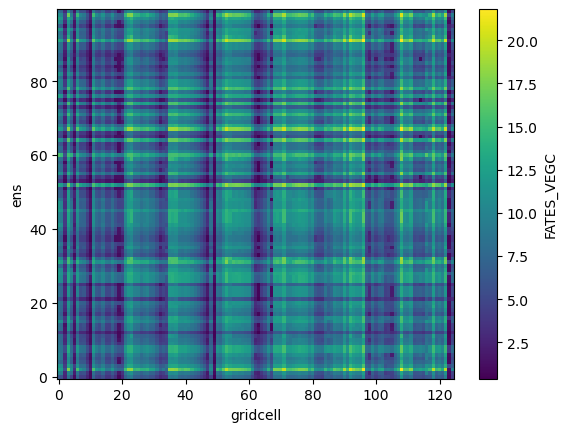

In [17]:
for pft in pfts:
    if(spmode==0):
        cuedatafile='outputs/cue_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
        vegcdatafile='outputs/vegc_output_'+str(ensN)+'_PFT-'+str(pft)+'.nc'
        print(vegcdatafile)
        cue_in=xr.open_dataset(cuedatafile)
        cue_in_pft.append(cue_in)
        cue_in.close()
        vegc_in=xr.open_dataset(vegcdatafile)
        
        vegc_in_pft.append(vegc_in)
        vegc_in.FATES_VEGC.plot()
        vegc_in.close()

### Find the values for the meshfile gridpoints in the ILAMB data

In [18]:
gppfile_m='/glade/work/rfisher/ILAMB_data/DATA/gpp/FLUXCOM/gpp.nc'
gppfile_w='/glade/work/rfisher/ILAMB_data/DATA/gpp/WECANN/gpp.nc'
laifile='/glade/work/rfisher/FATES_calibration/ILAMB_data/DATA/lai/MODIS/lai_0.5x0.5.nc'
etfile='/glade/work/rfisher/FATES_calibration/ILAMB_data/DATA/evspsbl/GLEAMv3.3a/et.nc'
vegcfile1='/glade/work/rfisher/FATES_calibration/ILAMB_data/DATA/biomass/ESACCI/biomass.nc'
vegcfile2='/glade/work/rfisher/FATES_calibration/ILAMB_data/DATA/biomass/Saatchi2011/biomass_0.5x0.5.nc'

In [19]:
#open ilamb data. 
ds_gpp_m = xr.open_dataset(gppfile_m)
ds_gpp_w = xr.open_dataset(gppfile_w)
ds_lai = xr.open_dataset(laifile)
ds_et = xr.open_dataset(etfile)
ds_vegc1 = xr.open_dataset(vegcfile1)
ds_vegc2 = xr.open_dataset(vegcfile2)

ds_gpp_m=ds_gpp_m.mean('time')
ds_gpp_w=ds_gpp_w.mean('time')
ds_lai=ds_lai.mean('time')
ds_lai['lat']=ds_lai.lat*-1
ds_et=ds_et.mean('time')
ds_et=ds_et*convet

ds_vegc1=ds_vegc1.mean('time')
ds_vegc2=ds_vegc2.mean('time')



### Find and open mesh file

In [20]:
import cartopy.crs as ccrs
meshroot='/glade/work/rfisher/FATES_calibration/mesh_files/'
meshfiles= os.listdir(meshroot)
lat_list_pft=[]
lon_list_pft=[]

for pft in pfts:
    target_string = 'pft'+str(pft)+'_'
    meshfile = [file for file in meshfiles if target_string in file]
    print(pft,meshfile)
    mesh=xr.open_dataset(meshroot+meshfile[0])
    latlon=mesh.where(mesh.elementMask == 1, drop=True).centerCoords.values
    #Convert the longitudes in the mesh file from 0-360 space to -180 to 180 space 
    #to be comparable to the ILAMB data files
    lat_mesh=latlon[:,1]
    lon_mesh=latlon[:,0]
    lat_list=lat_mesh
    lon_list=lon_mesh
    npoints=len(lon_list)
    for i in range(npoints):
        if(lon_list[i]>180):        
            lon_list[i]=(360-lon_list[i])*-1
    lon_list_pft.append(lon_list)
    lat_list_pft.append(lat_list)    

0 ['pft0_BET_grid_presence_mesh.nc']


### Extract the GPP and ET and LAI values for the lat lons in the mesh file

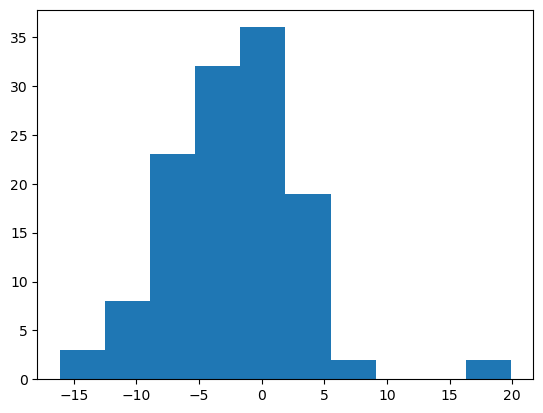

In [21]:
counter=0
for pft in pfts:
    plt.hist(lat_list_pft[counter])
    counter=counter+1

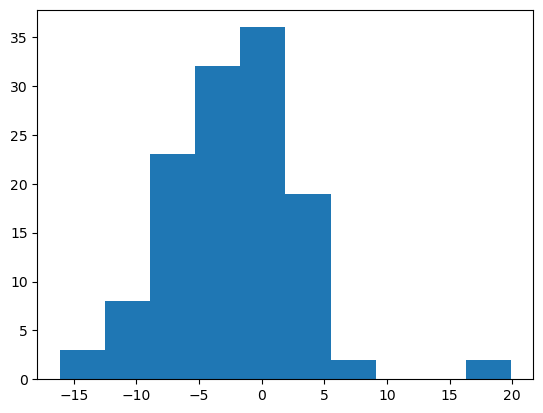

In [22]:
counter=0
for pft in pfts:
    plt.hist(lat_list_pft[counter])
    counter=counter+1

### Extract relevant data points from ILAMB data. 

125 (125,) (125,)
0 0 (125,)
maxlai <xarray.DataArray 'lai' ()>
array(5.88022184)
0 (125,)


<Figure size 2500x1500 with 0 Axes>

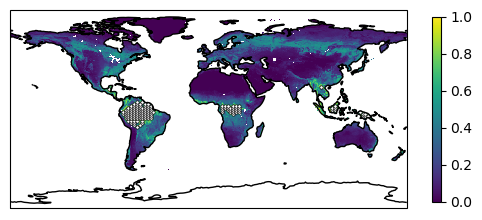

In [23]:
Xarr_lat_gpp = ds_gpp_m['lat']
Xarr_lon_gpp = ds_gpp_m['lon']

Xarr_lat_et = ds_et['lat']
Xarr_lon_et = ds_et['lon']

ds_lai['lat']=-ds_lai['lat']
Xarr_lat_lai = ds_lai['lat']
Xarr_lon_lai = ds_lai['lon']

Xarr_lat_vegc1 = ds_vegc1['lat']
Xarr_lon_vegc1 = ds_vegc1['lon']
Xarr_lat_vegc2 = ds_vegc2['lat']
Xarr_lon_vegc2 = ds_vegc2['lon']


npft=len(pfts)
array2d = np.zeros((3, 4))

gpp_wecann_SG_pft=[]
gpp_SG_pft=[]
et_SG_pft =[]
lai_SG_pft=[]
vegc1_SG_pft=[]
vegc2_SG_pft=[]

countp=0
for pft in pfts:
    nlat=int(len(lon_list_pft[countp]))
    gpp_SG=np.zeros(nlat)
    lai_SG=np.zeros(nlat)
    et_SG=np.zeros(nlat)
    vegc1_SG=np.zeros(nlat)
    vegc2_SG=np.zeros(nlat)
    print(nlat,np.shape(lai_SG),np.shape(lon_list_pft[countp]))

    for i in range(len(lat_list_pft[countp])):
        lat_i=lat_list_pft[countp][i]
        lon_i=lon_list_pft[countp][i]
        nearest_index_lat = np.abs(Xarr_lat_gpp - lat_i).argmin()
        nearest_index_lon = np.abs(Xarr_lon_gpp - lon_i).argmin()
        gpp_SG[i]=ds_gpp_m['gpp'][nearest_index_lat,nearest_index_lon]
              
        nearest_index_lat_et = np.abs(Xarr_lat_et - lat_i).argmin()
        nearest_index_lon_et = np.abs(Xarr_lon_et - lon_i).argmin()
        et_SG[i]=ds_et['et'][nearest_index_lat_et,nearest_index_lon_et]
     
        nearest_index_lat_lai = np.abs(Xarr_lat_lai - lat_i).argmin()
        nearest_index_lon_lai = np.abs(Xarr_lon_lai - lon_i).argmin()
        lai_SG[i]=ds_lai['lai'][nearest_index_lat_lai,nearest_index_lon_lai]

        nearest_index_lat_vegc1 = np.abs(Xarr_lat_vegc1 - lat_i).argmin()
        nearest_index_lon_vegc1 = np.abs(Xarr_lon_vegc1 - lon_i).argmin()
        vegc1_SG[i]=ds_vegc1['biomass'][nearest_index_lat_vegc1,nearest_index_lon_vegc1]
        
        nearest_index_lat_vegc2 = np.abs(Xarr_lat_vegc2 - lat_i).argmin()
        nearest_index_lon_vegc2 = np.abs(Xarr_lon_vegc2 - lon_i).argmin()
        vegc2_SG[i]=ds_vegc2['biomass'][nearest_index_lat_vegc2,nearest_index_lon_vegc2]

    
    et_SG_pft.append(et_SG)
    gpp_SG_pft.append(gpp_SG)         
    lai_SG_pft.append(lai_SG) 
    vegc1_SG_pft.append(vegc1_SG) 
    vegc2_SG_pft.append(vegc2_SG)    
    
    print(pft,countp,np.shape(lai_SG_pft[countp]))
    fig = plt.figure(figsize=(25, 15))         
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ds_lai.lai.plot(ax=ax, transform=ccrs.PlateCarree(),  vmin=0, cmap='viridis',add_colorbar=False)
    scatter = ax.scatter(lon_list_pft[countp], lat_list_pft[countp], c='white', cmap='viridis', marker='o', s=6, edgecolor='black',linewidth=0.5,transform=ccrs.PlateCarree())
    print('maxlai',np.max(ds_lai.lai))
    cbar = plt.colorbar(scatter, shrink=0.5)
    #plt.show()
    countp=countp+1
    figname=figdir+'/PFT_points_'+str(pft)+'.png'
    plt.savefig(figname)  
    
for i in range(len(pfts)):
    print(i,np.shape(lai_SG_pft[i]))

1 ['pft1_ENT_grid_presence_mesh.nc']
2 ['pft2_DNT_grid_presence_mesh.nc']


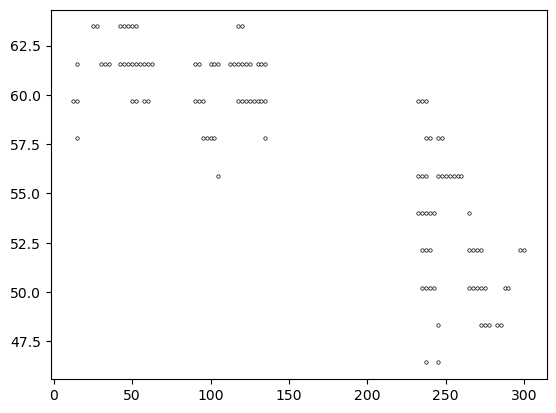

In [24]:
#surface dataset
fsurdat=xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.2.0/surfdata_1.9x2.5_hist_2000_16pfts_c240216.nc')
lai_ann=fsurdat.MONTHLY_LAI.mean('time')
pft=2
#lai_ann.isel(lsmpft=pft).plot()
#fsurdat.MONTHLY_LAI.mean('time')[3].plot()
pftl=[1,2]
for pft in [1, 2]:
    target_string = 'pft'+str(pft)+'_'
    meshfile = [file for file in meshfiles if target_string in file]
    print(pft,meshfile)
    mesh=xr.open_dataset(meshroot+meshfile[0])
    latlon=mesh.where(mesh.elementMask == 1, drop=True).centerCoords.values
    #Convert the longitudes in the mesh file from 0-360 space to -180 to 180 space 
    #to be comparable to the ILAMB data files
    lat_mesh=latlon[:,1]
    lon_mesh=latlon[:,0]

    plt.scatter(lon_mesh, lat_mesh, c='white', cmap='viridis', marker='o', s=6, edgecolor='black',linewidth=0.5)


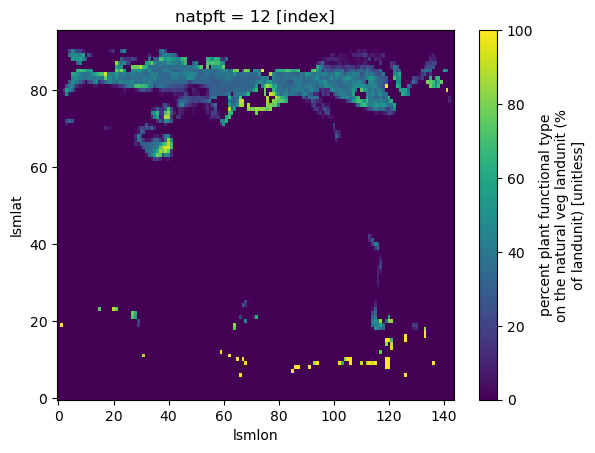

In [25]:
fsurdat.PCT_NAT_PFT[12].plot()


### 10.1 Plot the LAI ensemble space per PFT

In [26]:
for i in range(len(pfts)):
    print(i,np.shape(lai_SG_pft[i]))
    print(i,np.max(lai_in_pft[i].FATES_LAI))
    print(i, np.shape(lai_SG_pft[i]))

0 (125,)
0 <xarray.DataArray 'FATES_LAI' ()>
array(20.34430313)
0 (125,)


In [27]:
def plot_ensemble_range(var_in_pft,var,var_SG_pft):
    plot_range=1
    ncls= ncls_pft
    rw=max(1,int(len(pfts)/ncls))

    if(plot_range==1): 
        fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(25, 8))
        plt.subplots_adjust(wspace=0.15, hspace=0.25)
    
        axcount=0
        countp=0
        for p in pfts: # pfts to select. 
            col = countp % ncls
            axc=col   
            if(rw>1):
                row = axcount //ncls
                axc=[row,col]
            varens=var_in_pft[countp][var]
            ngcells=len(np.mean(varens,0))
            print('ngcells',ngcells)
            xgcells=range(ngcells)
            xvar = [list(xgcells) for _ in range(len(varens))]
    
            if np.shape(varens)[1] <20:
                for e in range(ncases): 
                    axes[axc].scatter(xgcells,varens,color=plt.cm.tab10(e),s=18,label='ens #'+str(e))
            else:
                print(np.shape(xvar),np.shape(varens))
                axes[axc].scatter(xvar,varens,color='grey',s=8)
            axes[axc].scatter(xgcells, var_SG_pft[countp],color='blue',s=100,marker='x')        
            axes[axc].set_ylabel(var, fontsize=26) 
           # axes[axc].set_ylim([0,9]) 
            axes[axc].set_title('PFT'+str(p), fontsize=26) 
            axes[axc].set_xlabel('Gridcell', fontsize=20)
            countp=countp+1

        #while axcount < rw*ncls:
        #    row = axcount //ncls
        #    col = axcount %ncls
        #    axes[axc].remove()
            axcount += 1
        figname=figdir+'/range_vs_data_'+var+'_y'+str(ychoose)+'Nens_'+str(ensN)+'.png'
        plt.savefig(figname,bbox_inches='tight')  
        plt.show()
        print(figname)
        countp=countp+1

ngcells 125
(100, 125) (100, 125)


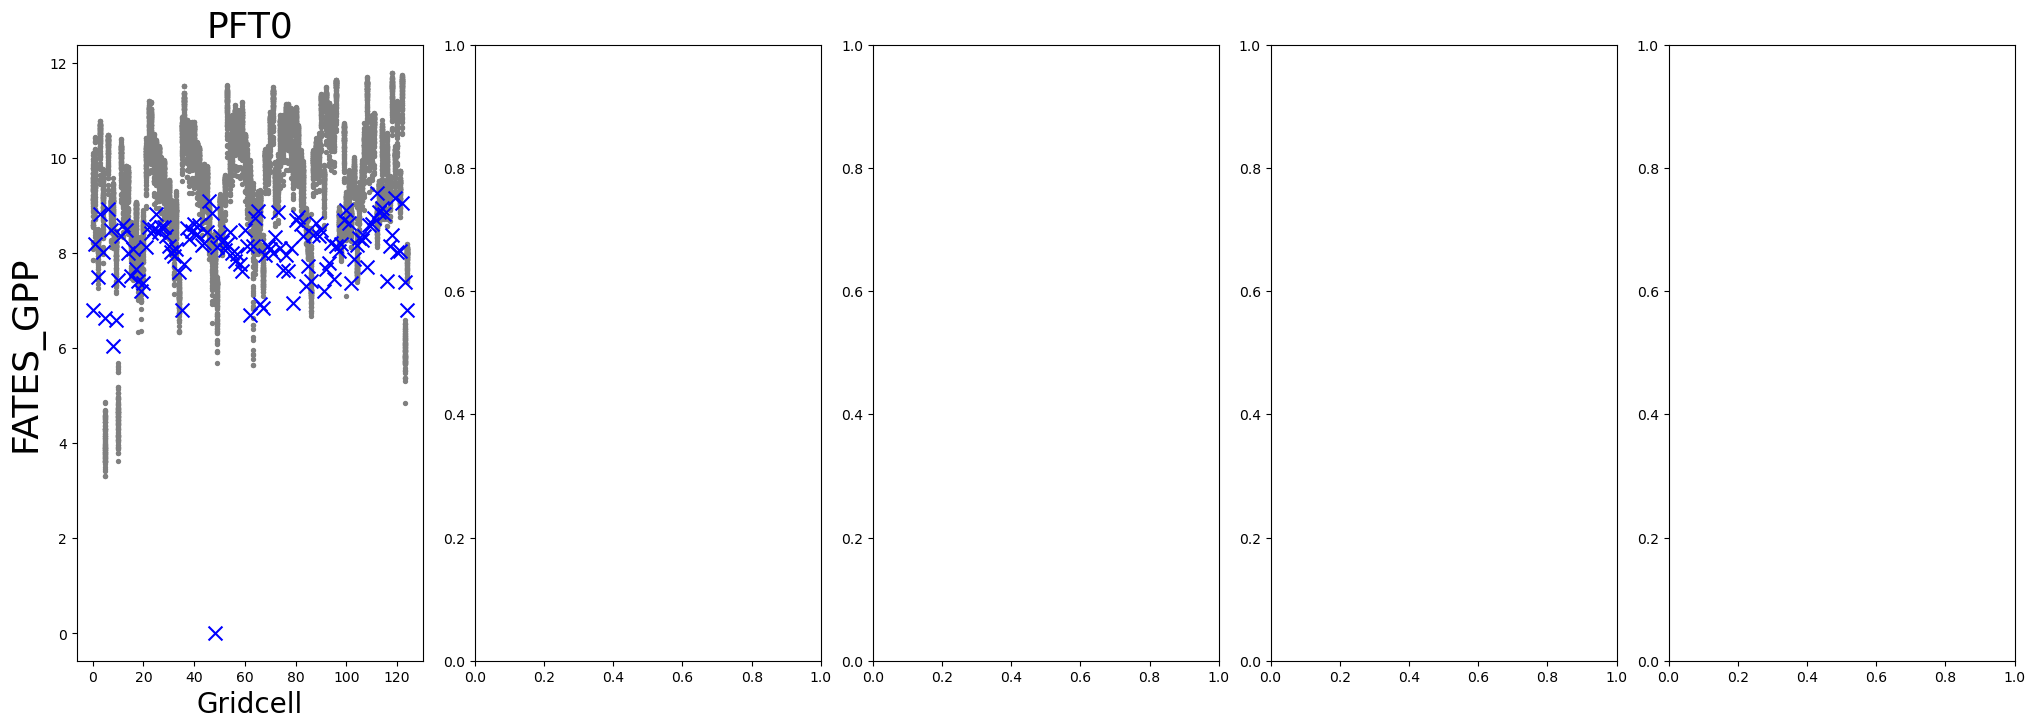

/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_//range_vs_data_FATES_GPP_y19Nens_16.png


In [28]:
#print('sh1',np.shape(gpp_in_pft[1]))
plot_ensemble_range(gpp_in_pft,'FATES_GPP',gpp_SG_pft)

ngcells 125
(100, 125) (100, 125)


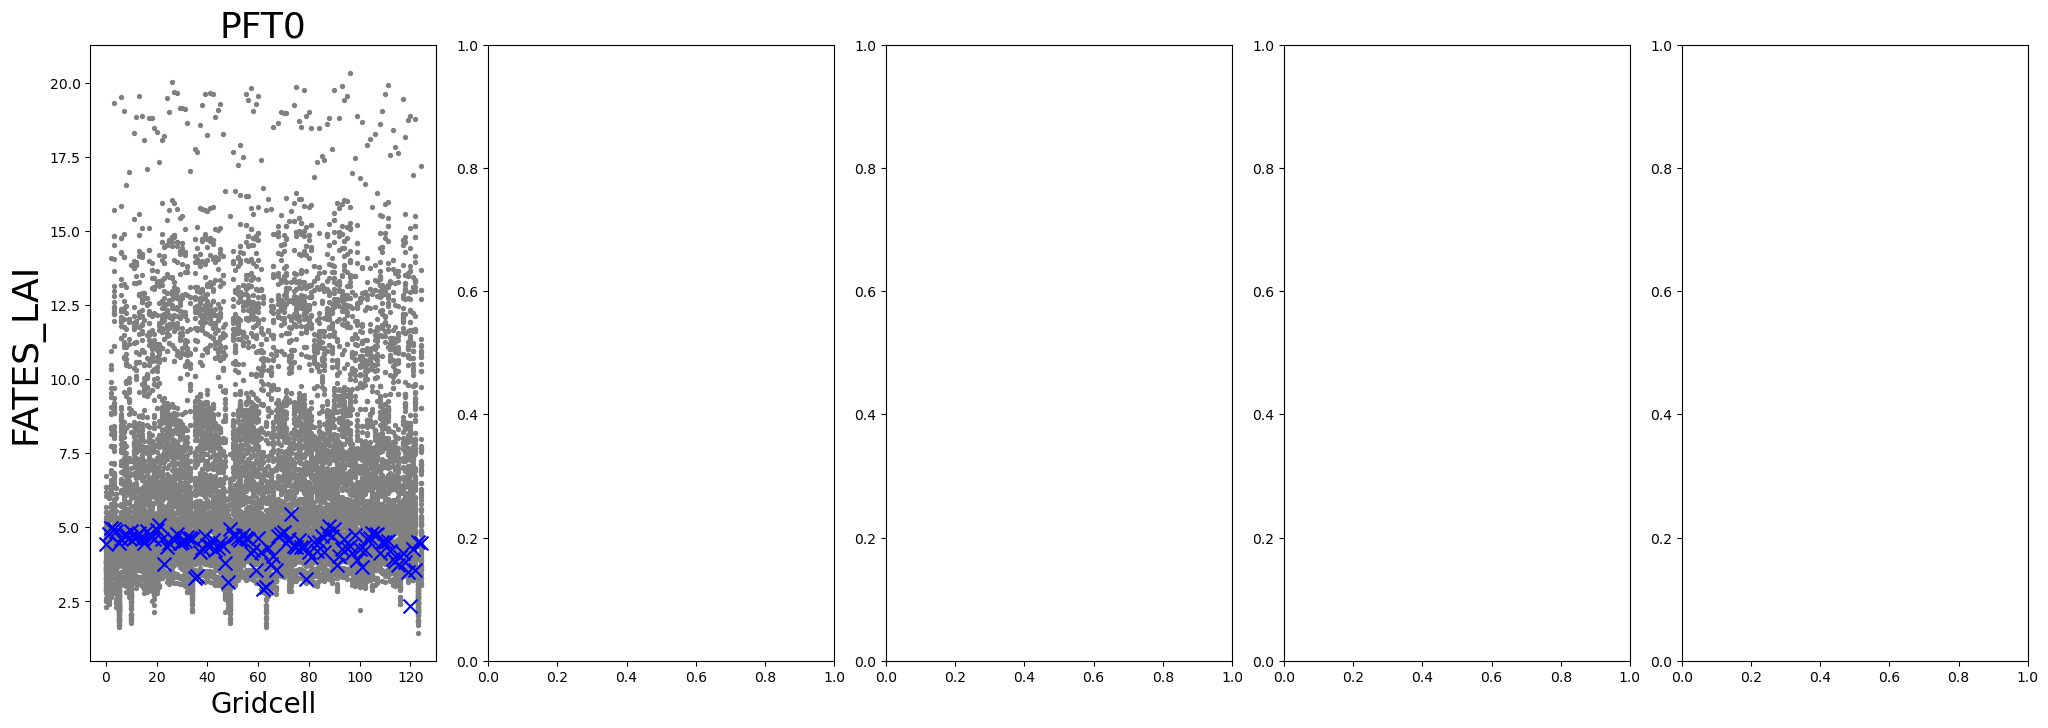

/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_//range_vs_data_FATES_LAI_y19Nens_16.png


In [29]:
plot_ensemble_range(lai_in_pft,'FATES_LAI',lai_SG_pft)

ngcells 125
(100, 125) (100, 125)


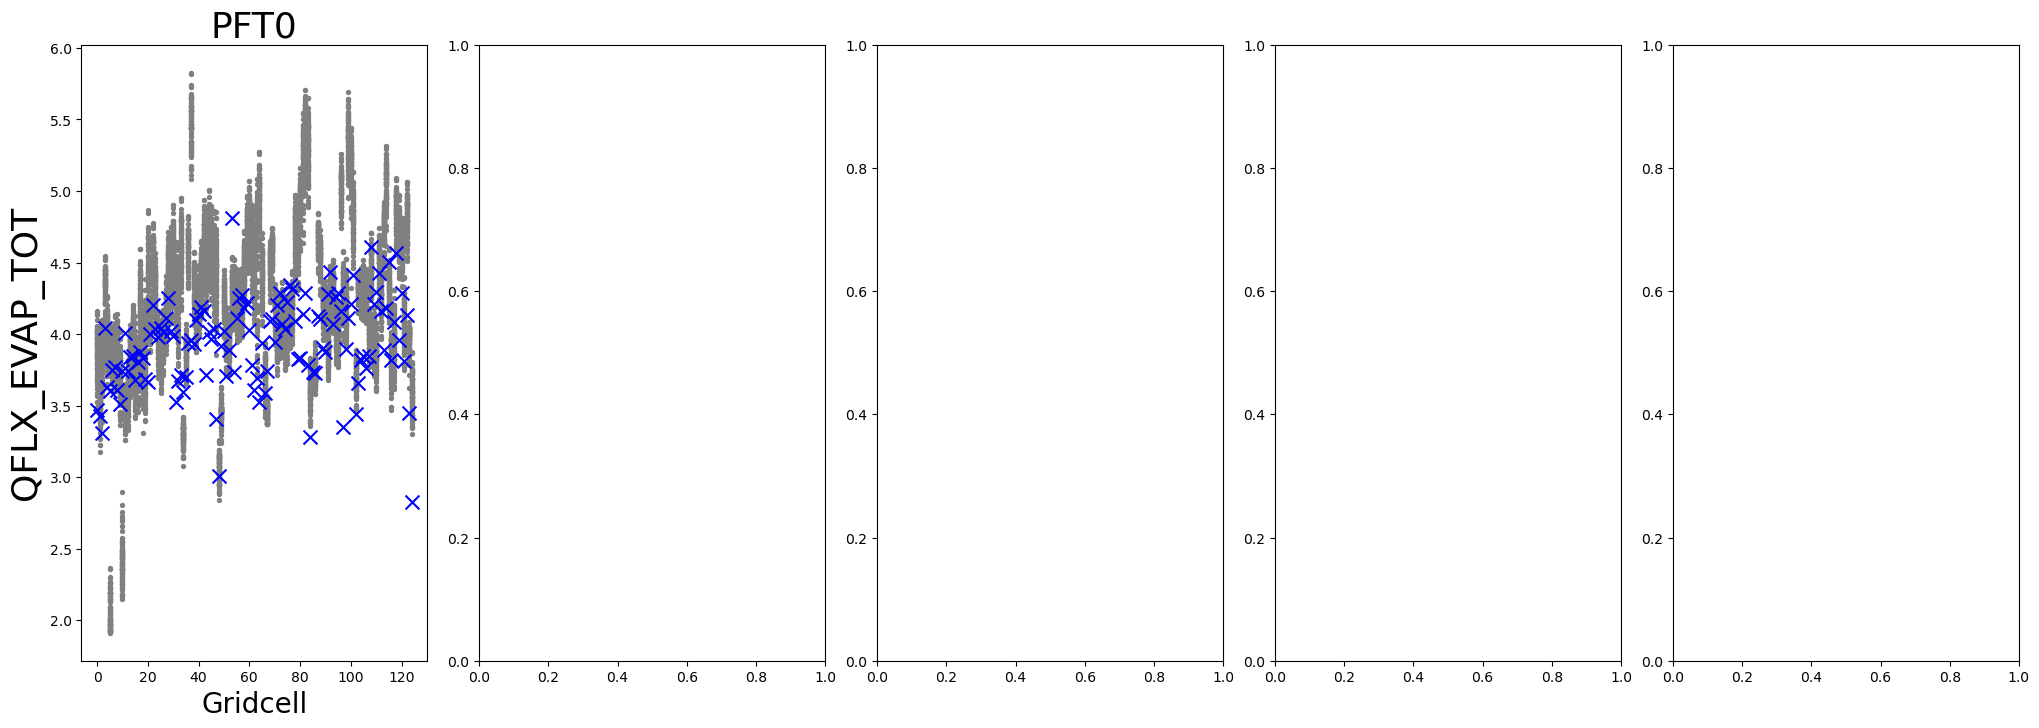

/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_//range_vs_data_QFLX_EVAP_TOT_y19Nens_16.png


In [30]:
plot_ensemble_range(et_in_pft,'QFLX_EVAP_TOT',et_SG_pft)

In [31]:
if(spmode==0):
    plot_ensemble_range(vegc_in_pft[0]['FATES_VEGC']).plot()

TypeError: plot_ensemble_range() missing 2 required positional arguments: 'var' and 'var_SG_pft'

### Surrogate Models.

### 13.2 Linear Regression

In [32]:

def linear_regression(g,fgs, axes, row, col,vnonan):
    yall=vnonan[:,g]
    if np.ndim(yall)==2:   
        yall=np.mean(yall,1)
    nan_indices = yall.isnull()
    yall[np.isnan(yall)] = np.mean(yall)   
    X=x_array
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    
    model = sm.OLS(y_train, X_train).fit()  # Fit the multivariate linear regression model
   # print(model.summary())
    predictions = model.predict(X_test)
    tr_predictions = model.predict(X)
    if(fgs==1):
        #map_param_space(g)
        axes[row,col].scatter(y_test,predictions,color='green',label='Linear Regression')
        #plt.scatter(tr_predictions,y)
    residuals = model.resid

# Calculate the standard deviation of predictions
  #  std_dev_predictions = residuals.std()
  #  rel_dev=np.divide(std_dev_predictions,np.mean(y))

    r_squared = stats.pearsonr(predictions, y_test)[0] ** 2
    return r_squared
    

### 13.3 Gaussian Process emulator

In [33]:

def make_emulator_for_point(g,fgs, axes, row, col,vn):
    yall=vn[:,g]

    if np.ndim(yall)==2:     
        yall=np.mean(yall,1)
    nan_indices = yall.isnull()
    yall[np.isnan(yall)] = np.mean(yall)
    yall=yall[0:len(x_array)]
    X=x_array[0:len(yall),:]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    mask = np.where(np.isinf(y_train))
    y_train[mask]=0.5    
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    y_pred =gp.fit(X_train, y_train)
    test_prediction, std_prediction = gp.predict(X_test, return_std=True)
    #r2 = r2_score(ytest, test_prediction) 
    
    if(np.max(test_prediction)==0):
        print('emulator fail')
    else:
        print('mean pred',np.mean(test_prediction))
    

    if(fgs==1 ):
        if(multp==1):
            ax=axes[row,col]
        else:
            ax=axes
            
        ax.scatter(y_test,test_prediction, color='red', marker='o',label='GP emulator')
        ax.legend(loc='upper left')
        #ax.scatter(test_prediction,ytest)
        #ax.set_xlabel('LAI emulator')
        #ax.set_ylabel('LAI FATES')

    r_squared = stats.pearsonr(test_prediction, y_test)[0] ** 2
    return r_squared
    

###  Random forest

In [34]:
def random_forest(fgs,feat, axes,axc,multp,vnonan):
    yall=vnonan  
    if(ensN==150):
        gpp=yall.isel(ens=1)
        mask = ~np.isnan(gpp)
        vmeans=np.zeros(ncases)
        for i in range(ncases):
            gpp_i=vnonan.isel(ens=i)
            gpp_i_1d = gpp_i.values[mask]
            vmeans[i]=np.mean(gpp_i_1d)
            yall=vmeans
    else:    
        if np.ndim(yall)==2:     
            yall=np.mean(yall,1)
    
        nan_indices = yall.isnull()
        yall[np.isnan(yall)] = np.mean(yall)

    
    yall=yall[0:len(x_array)]
    X=x_array[0:len(yall),:]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,yall, test_size=0.2, random_state=42)
    mask = np.where(np.isinf(y_train))
    y_train[mask]=0.5
    # Create a random forest regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model to the training data
    rf_model.fit(X_train, y_train)
    rf_models.append(rf_model)

    # Make predictions on the testing data
    y_pred = rf_model.predict(X_test)
    print('ypred',np.min(y_pred),np.max(y_pred))
    if(fgs==1 ):
        if(multp==1):
            ax=axes[axc]
        else:
            ax=axes[axc]
       # map_param_space(g)
        #fig = plt.figure()
        print('axc',axc)

        axes[axc].scatter(y_test,y_pred,color='blue',s=20,label='Random Forest')
        axes[axc].plot([min(y_pred),max(y_pred)],[min(y_pred),max(y_pred)],color='black')
            #plt.scatter(tr_predictions,y)
        #axes[row,col].title('g='+str(g)+' Lat:'+str(round(glat[g], 2))+' Lon:'+str(round(glon[g], 2)))

    r_squared = stats.pearsonr(y_pred, y_test)[0] ** 2
    if(feat==1):
        feature_importances = rf_model.feature_importances_
    
    # Create a DataFrame to display the feature importances
        #feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        #feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
        feature_importances_df = pd.DataFrame({'Feature Importance': feature_importances})
        feature_importances_df['FeatureIndex'] = range(0, len(feature_importances_df) )

        feature_importances_df = feature_importances_df.sort_values(by='Feature Importance', ascending=False)
    
        # Display the dominant factors
        #print(feature_importances_df.FeatureIndex.iloc[1:4])
        featimp=feature_importances_df.FeatureIndex.iloc[0:4]
    return rf_model,r_squared,featimp

    
### 15. Make a large hypercube encompassing the whole parameter space 

In [35]:
num_samples=5000
num_variables = len(lhc_vars)
hypercube = np.zeros((num_samples, num_variables))
for i in range(num_variables):
    hypercube[:, i] = np.random.permutation(np.linspace(0, 1, num_samples))

hypercube_scaled=np.zeros((num_samples, num_variables))
#for i  in range(5):
for i, var in enumerate(lhc_vars):
    mx=np.max(x_array[:,i])
    mn=np.min(x_array[:,i])
    print(var,mn,mx)
    for e in range(num_samples):
        hypercube_scaled[e,i]=(hypercube[e,i]*(mx-mn))+mn
Xdense=hypercube_scaled
print('hypercube shape',np.shape(Xdense))
### 16 Find simulations with acceptable LAI and CUE

 

fates_maintresp_leaf_atkin2017_baserate 1.7 1.8
fates_maintresp_leaf_vert_scaler_coeff2 0.486 2.43
fates_allom_d2bl1 0.05400000000000002 0.10800000000000004
fates_turnover_leaf 0.7283333333333334 1.3541666666666667
fates_allom_d2ca_coefficient_min 0.12385785013333338 0.5954704333333334
fates_stoich_nitr 0.011555835083333335 0.021460836583333337
fates_leaf_slatop 0.020399999999999998 0.029466666666666665
hypercube shape (5000, 7)


### 14.  Run emulators

ncls,rw 5 1
['QFLX_EVAP_TOT', 'FATES_GPP', 'FATES_LAI', 'FATES_NPP', 'FATES_VEGC']
vn [<xarray.Dataset>
Dimensions:        (ens: 100, gridcell: 125)
Dimensions without coordinates: ens, gridcell
Data variables:
    QFLX_EVAP_TOT  (ens, gridcell) float64 3.71 3.383 3.643 ... 4.845 4.005 3.56]
v 0
p,v 0 0
axc 0
ypred 4.028941103990195 4.327532185658813
axc 0
rsq 0.7139931207782934 0 0
1


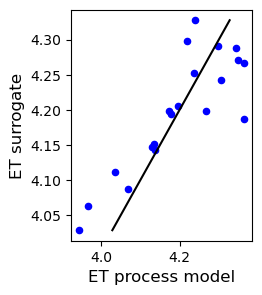

vn [<xarray.Dataset>
Dimensions:    (ens: 100, gridcell: 125)
Dimensions without coordinates: ens, gridcell
Data variables:
    FATES_GPP  (ens, gridcell) float64 8.656 8.882 7.422 ... 11.49 6.25 8.082]
v 1
p,v 0 1
axc 0
ypred 9.213785138193089 9.683297378003772
axc 0
rsq 0.5775858854327627 0 0
1


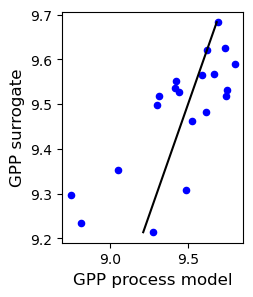

vn [<xarray.Dataset>
Dimensions:    (ens: 100, gridcell: 125)
Dimensions without coordinates: ens, gridcell
Data variables:
    FATES_LAI  (ens, gridcell) float32 3.035 3.015 2.871 ... 6.539 2.595 5.247]
v 2
p,v 0 2
axc 0
ypred 4.391494879722595 11.171458806991577
axc 0
rsq 0.51553245274931 0 0
1


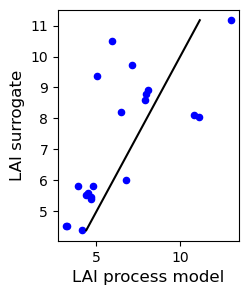

vn [<xarray.Dataset>
Dimensions:    (ens: 100, gridcell: 125)
Dimensions without coordinates: ens, gridcell
Data variables:
    FATES_NPP  (ens, gridcell) float32 ...]
v 3
p,v 0 3
axc 0
ypred 0.3521019607782364 0.6185379129648209
axc 0
rsq 0.7782969574974287 0 0
1


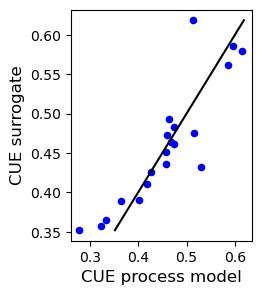

vn [<xarray.Dataset>
Dimensions:     (ens: 100, gridcell: 125)
Dimensions without coordinates: ens, gridcell
Data variables:
    FATES_VEGC  (ens, gridcell) float32 ...]
v 4
p,v 0 4
axc 0
ypred 5.360651636123658 12.003606443405152
axc 0
rsq 0.8230472520122596 0 0
1


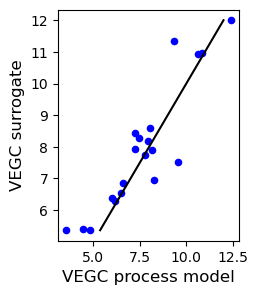

IndexError: index 1 is out of bounds for axis 0 with size 1

In [36]:
# Make empty lists for statistical models
rf_st=np.zeros(355)
lr_st=np.zeros(355)
gp_st=np.zeros(355)
rf_models_et=[]
rf_models_gpp=[]
rf_models_lai=[]
rf_models_cue=[]
rf_models_vegc=[]

y_pred_noise_et_pft=[]
y_pred_noise_gpp_pft=[]
y_pred_noise_lai_pft=[]
y_pred_noise_cue_pft=[]
y_pred_noise_vegc_pft=[]

ncls=ncls_pft
rw=max(int(len(pfts)/ncls)+1,1)
rw=1
print('ncls,rw',ncls,rw)
feat_importance = np.zeros([len(pfts),4,5], dtype=int)

vnonan=[et_in_pft,gpp_in_pft]
vars=['QFLX_EVAP_TOT','FATES_GPP']
if(spmode==0):
    vars=['QFLX_EVAP_TOT','FATES_GPP','FATES_LAI','FATES_NPP','FATES_VEGC']
    vnonan=[et_in_pft,gpp_in_pft,lai_in_pft,cue_in_pft,vegc_in_pft]   
print(vars)
for v, vn in enumerate(vnonan): 
    print('vn',vn)
    fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(14, 3))
    plt.subplots_adjust(wspace=0.25, hspace=0.12)
    multp=1
    rf_models = []
    rf_st=np.zeros(max(pfts))
    axcount=0
    for i in range(len(pfts)):
        print('v',v)
        var_pft=vn[axcount][vars[v]]           
        p=pfts[i]
        print('p,v',p,v)
        col = axcount % ncls 
        axc=col   
        if(rw>1):
            row = axcount //ncls
            axc=[row,col]  
        axcount=axcount+1
        print('axc',axc)
        rf_model,rsq,feat_importance[i,:,v]=random_forest(1,1,axes, axc,multp,var_pft)
        #make_emulator_for_point(gcells_pft[p],1, axes, row, col,vn)
        print('rsq',rsq,i,axc)
        axes[axc].set_xlabel(vars_bm[v]+' process model',fontsize=12)
        axes[axc].set_ylabel(vars_bm[v]+' surrogate',fontsize=12)
      # axes[axc].set_title(sg_data['pft'].values[p].title(),fontsize=16)
        if(v==0):        
            y_pred_noise_et_pft.append(rf_model.predict(Xdense))
        elif v==1:
            y_pred_noise_gpp_pft.append(rf_model.predict(Xdense))
        if(spmode==0): 
            if v==2:
                y_pred_noise_lai_pft.append(rf_model.predict(Xdense))
            elif v==3:
                y_pred_noise_cue_pft.append(rf_model.predict(Xdense))
            elif v==4:
                y_pred_noise_vegc_pft.append(rf_model.predict(Xdense))

    print(axcount)                
    while axcount < rw*ncls:
        col = axcount % ncls 
        axc=col   
        if(rw>1):
            row = axcount //ncls
            axc=[row,col]  
        axes[axc].remove()
        axcount += 1

    plt.savefig(figdir+'/PFT_level_RF_fit_'+vars_bm[v]+'_y'+str(ychoose)+'Nens_'+str(ensN)+'.png',bbox_inches='tight')  
    plt.show()

print(feat_importance[1,1,1])

### Find mean observed LAI, GPP, ET per PFT

In [37]:

et_pft=np.zeros(max(pfts)+1)
lai_pft=np.zeros(max(pfts)+1) 
gbaf_gpp_pft=np.zeros(max(pfts)+1)

countp=0
for p in pfts:
    mask = np.isfinite(et_SG_pft[countp])
    et_pft[p] = np.mean(et_SG_pft[countp][mask])
    mask = np.isfinite(gpp_SG_pft[countp])
    gbaf_gpp_pft[p] = np.mean(gpp_SG_pft[countp][mask])
    if(spmode==0):
        mask = np.isfinite(lai_SG_pft[countp])
        lai_pft[p] = np.mean(lai_SG_pft[countp][mask])
        
    countp=countp+1
print(et_pft)
print(gbaf_gpp_pft)
print(lai_pft)

[3.93317417]
[8.02889465]
[4.36820592]


### Find acceptable models

In [38]:
   
def find_acceptable_models(rfm,p,pftfit,vartoggle,fates_ens,fates_or_surrogate):
    fates_ens_mean=fates_ens.mean('gridcell')
    fates_ens_mean.plot() 
    print('fatesens',np.shape(fates_ens),np.shape(fates_ens_mean),fates_ens.dims)
    if vartoggle==0:
        y_pred_noise=y_pred_noise_et_pft[rfm]
        etmin=et_pft[p]-0.1*et_pft[p]
        etmax=et_pft[p]+0.1*et_pft[p]
        print('et minmax',np.min(y_pred_noise),np.max(y_pred_noise))
        y_accept=np.where(np.logical_and(y_pred_noise>=etmin, y_pred_noise<=etmax))   
        y_accept_ens= np.where(np.logical_and(fates_ens_mean>=etmin, fates_ens_mean<=etmax))  
        print('et range',etmin,etmax,et_pft[p],np.shape(y_accept))
    elif vartoggle==1:
        y_pred_noise=y_pred_noise_gpp_pft[rfm]
        gppmin=gbaf_gpp_pft[p]-0.1*gbaf_gpp_pft[p]
        gppmax=gbaf_gpp_pft[p]+0.1*gbaf_gpp_pft[p]
        y_accept=np.where(np.logical_and(y_pred_noise>=gppmin, y_pred_noise<=gppmax))   
        y_accept_ens= np.where(np.logical_and(fates_ens_mean>=gppmin, fates_ens_mean<=gppmax))  
        print('gpprange',gppmin,gppmax,np.shape(y_accept))
    if spmode==0:
        if(vartoggle==2): 
            y_pred_noise=y_pred_noise_lai_pft[rfm]
            if(pftfit==1):
                ldmin=lai_pft[p]-0.1*lai_pft[p]
                ldmax=lai_pft[p]+0.1*lai_pft[p]
            y_accept=np.where(np.logical_and(y_pred_noise>=ldmin, y_pred_noise<=ldmax))   
            y_accept_ens= np.where(np.logical_and(fates_ens_mean>=ldmin, fates_ens_mean<=ldmax))  
            print('lai range',p,ldmin,ldmax,np.shape(y_accept))
            print('lai range emul',p,np.min(y_pred_noise),np.max(y_pred_noise),np.shape(y_accept))
        elif vartoggle==3:
            y_pred_noise=y_pred_noise_cue_pft[rfm]
            cuemin=0.45 #cue_pft_mean[p]-0.5*cue_pft_std[p]
            cuemax=0.55 #cue_pft_mean[p]+0.5*cue_pft_std[p]  
            y_accept=np.where(np.logical_and(y_pred_noise>=cuemin, y_pred_noise<=cuemax))   
            y_accept_ens= np.where(np.logical_and(fates_ens_mean>=cuemin, fates_ens_mean<=cuemax))  
            print('cuerange',cuemin,cuemax,np.shape(y_accept))
        elif vartoggle==4:
            y_pred_noise=y_pred_noise_vegc_pft[rfm]
            vegcmin=6 #cue_pft_mean[p]-0.5*cue_pft_std[p]
            vegcmax=8 #cue_pft_mean[p]+0.5*cue_pft_std[p]  
            y_accept=np.where(np.logical_and(y_pred_noise>=vegcmin, y_pred_noise<=vegcmax))   
            y_accept_ens= np.where(np.logical_and(fates_ens_mean>=vegcmin, fates_ens_mean<=vegcmax))  
            print('vegcrange',vegcmin,vegcmax,np.shape(y_accept))


    if(fates_or_surrogate==0):
        return y_accept_ens
    else:
        return y_accept

pft 0
fatesens (100, 125) (100,) ('ens', 'gridcell')
et minmax 4.012334931816912 4.399478877379095
et range 3.5398567573717794 4.326491592343286 3.9331741748575326 (1, 4579)
fatesens (100, 125) (100,) ('ens', 'gridcell')
gpprange 7.226005188330262 8.83178411907032 (1, 0)
fatesens (100, 125) (100,) ('ens', 'gridcell')
et minmax 4.012334931816912 4.399478877379095
et range 3.5398567573717794 4.326491592343286 3.9331741748575326 (1, 4579)
fatesens (100, 125) (100,) ('ens', 'gridcell')
gpprange 7.226005188330262 8.83178411907032 (1, 0)
fatesens (100, 125) (100,) ('ens', 'gridcell')
lai range 0 3.9313853324890133 4.805026517486572 (1, 532)
lai range emul 0 3.4274409222602844 12.447631130218506 (1, 532)
fatesens (100, 125) (100,) ('ens', 'gridcell')
cuerange 0.45 0.55 (1, 2366)
fatesens (100, 125) (100,) ('ens', 'gridcell')
vegcrange 6 8 (1, 1728)
fatesens (100, 125) (100,) ('ens', 'gridcell')
lai range 0 3.9313853324890133 4.805026517486572 (1, 532)
lai range emul 0 3.4274409222602844 12.44

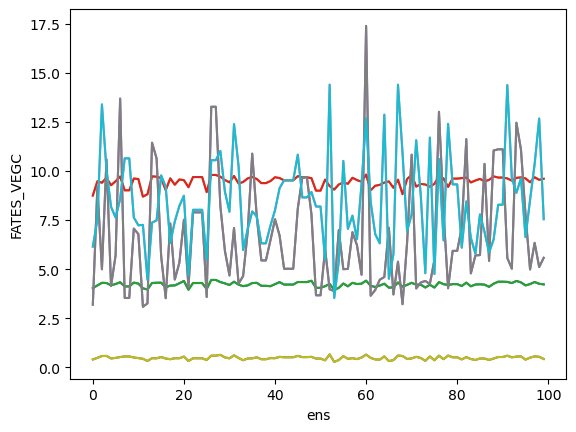

In [39]:
pftfit=1

accept_lai_i = []
accept_et_i = []
accept_gpp_i = []
accept_cue_i = []
accept_vegc_i = []
accept_both_i = []

accept_lai_ens_i = []
accept_et_ens_i = []
accept_gpp_ens_i = []
accept_cue_ens_i = []
accept_vegc_ens_i = []
accept_both_ens_i = []


if(pftfit==1):
    for rfm in range(len(pfts)):        
        p=pfts[rfm]   
        print('pft',p)

        accept_et_i.append(find_acceptable_models(rfm,p,pftfit,0,et_in_pft[rfm][vars[0]],1))
        accept_gpp_i.append(find_acceptable_models(rfm,p,pftfit,1,gpp_in_pft[rfm][vars[1]],1))
        accept_et_ens_i.append(find_acceptable_models(rfm,p,pftfit,0,et_in_pft[rfm][vars[0]],0))
        accept_gpp_ens_i.append(find_acceptable_models(rfm,p,pftfit,1,gpp_in_pft[rfm][vars[1]],0))

        if(spmode==0):              
            accept_lai_i.append(find_acceptable_models(rfm,p,pftfit,2,lai_in_pft[rfm][vars[2]],1))
            accept_cue_i.append(find_acceptable_models(rfm,p,pftfit,3,cue_in_pft[rfm][vars[3]],1))
            accept_vegc_i.append(find_acceptable_models(rfm,p,pftfit,4,vegc_in_pft[rfm][vars[4]],1))
 
            accept_lai_ens_i.append(find_acceptable_models(rfm,p,pftfit,2,lai_in_pft[rfm][vars[2]],0))
            accept_cue_ens_i.append(find_acceptable_models(rfm,p,pftfit,3,cue_in_pft[rfm][vars[3]],0))
            accept_vegc_ens_i.append(find_acceptable_models(rfm,p,pftfit,4,vegc_in_pft[rfm][vars[4]],0))
        
else: # gridcell fit  
    for rfm in range(len(gcells)):
        g=gcells[i]        
        accept_lai_i.append(find_acceptable_models(rfm,g,pftfit))  


### Draw selected parameter space

In [40]:
def draw_selected_param_space(rfm,p,pftfit,vtoggle):
    ncls=ncls_param
    print('vtogggle',vtoggle)
    if ncls==5: 
        tsz=16
        ysz=14
        xsz=14
        ht=16
        psz=9
    if ncls==4 :
        tsz=18
        ysz=18
        xsz=18
        ht=13
        psz=14
    #colors = plt.get_cmap('tab10').colors
    #colors = plt.get_cmap('CSS4_COLORS').colors

    # Choosing a specific color from the Tableau color palette
          
    axcount=0

    y_accept_et=accept_et_i[rfm]
    y_accept_gpp=accept_gpp_i[rfm]
    if(spmode==0):
        y_accept_cue=accept_cue_i[rfm]
        y_accept_lai=accept_lai_i[rfm]    
        
    if(vtoggle==0):
        y_pred_noise  = y_pred_noise_et_pft[rfm]
        fatesens=et_in_pft[rfm].QFLX_EVAP_TOT[0:len(x_array)]
        vlab='ET'
        minv=et_pft[p]-0.1*et_pft[p] 
        rangev=0.2*et_pft[p] 

    elif vtoggle==1:
        y_pred_noise  = y_pred_noise_gpp_pft[rfm]
        fatesens=gpp_in_pft[rfm].FATES_GPP[0:len(x_array)]
        vlab='GPP KgC/m2/year'
        minv=gbaf_gpp_pft[p]-0.1*gbaf_gpp_pft[p] 
        rangev=0.2*gbaf_gpp_pft[p] 


    if(spmode==0):
        if vtoggle==2:
            y_pred_noise  = y_pred_noise_lai_pft[rfm]
            fatesens=lai_in_pft[rfm].FATES_LAI[0:len(x_array)]
            minv=lai_pft[p]-0.1*lai_pft[p] 
            rangev=0.2*lai_pft[p] 
            vlab='LAI'
        elif vtoggle==3:
            y_pred_noise  = y_pred_noise_cue_pft[rfm]
            fatesens=cue_in_pft[rfm].FATES_NPP[0:len(x_array)]
            vlab='GPP KgC/m2/year'
            minv=0.45
            rangev=0.1
        elif vtoggle==4:
            y_pred_noise  = y_pred_noise_vegc_pft[rfm]
            fatesens=vegc_in_pft[rfm].FATES_VEGC[0:len(x_array)]
            vlab='GPP KgC/m2'
            minv=6
            rangev=3

    Xsh=Xdense.shape
    rw=int(len(lhc_vars)/ncls)+1
    fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(22, ht)) 
    #pftname=sg_data['pft'].values[p].title()
    #fig.suptitle(pftname,fontsize=tsz,y=0.9)
    plt.subplots_adjust(wspace=0.15, hspace=0.35)  
    pftfit=1
    axcount=0
    
    
    for v, var in enumerate(lhc_vars):  
        row = axcount //ncls
        col = axcount % ncls  
        axcount=axcount+1
        ap=1

        #add a box of the observed range
        rangexavars=np.max(Xdense[:,v])-np.min(Xdense[:,v])
        rect = patches.Rectangle((np.min(Xdense[:,v]),minv ), rangexavars, rangev, linewidth=1, edgecolor='grey',alpha=0.6, facecolor=chosen_color_target)
        axes[row, col].add_patch(rect)
        
        axes[row, col].scatter(Xdense[:,v], y_pred_noise, color=chosen_color_all,s=2)    

        axes[row, col].scatter(Xdense[y_accept_et,v], y_pred_noise[y_accept_et], color=chosen_color_et,s=4, alpha=ap) 
        axes[row, col].scatter(Xdense[y_accept_gpp,v], y_pred_noise[y_accept_gpp], color=chosen_color_gpp,s=4, alpha=ap)

        
        if(spmode==0):
            axes[row, col].scatter(Xdense[y_accept_lai,v], y_pred_noise[y_accept_lai], color=chosen_color_lai,s=4, alpha=ap) 
            axes[row, col].scatter(Xdense[y_accept_cue,v], y_pred_noise[y_accept_cue], color=chosen_color_cue,s=4, alpha=ap) 

        #  Plot out the FATES sensemble outputs. 
        axes[row, col].scatter(x_array[:,v],  fatesens[:,:].mean(dim='gridcell'), s=psz, edgecolor='black',color='black')
 
        axes[row, col].set_xlabel(lhc_vars_title[v], fontsize=xsz)   
        if(col==0):
            axes[row, col].set_ylabel(vars_bm[vtoggle], fontsize=ysz)   
            
    while axcount < rw*ncls:
        row = axcount //ncls
        col = axcount %ncls
        axes[row, col].remove()
        axcount += 1

pfts [0]
ip 0 0
vtogggle 0
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_//emulator_and_ensemble_16_ET_p0.png


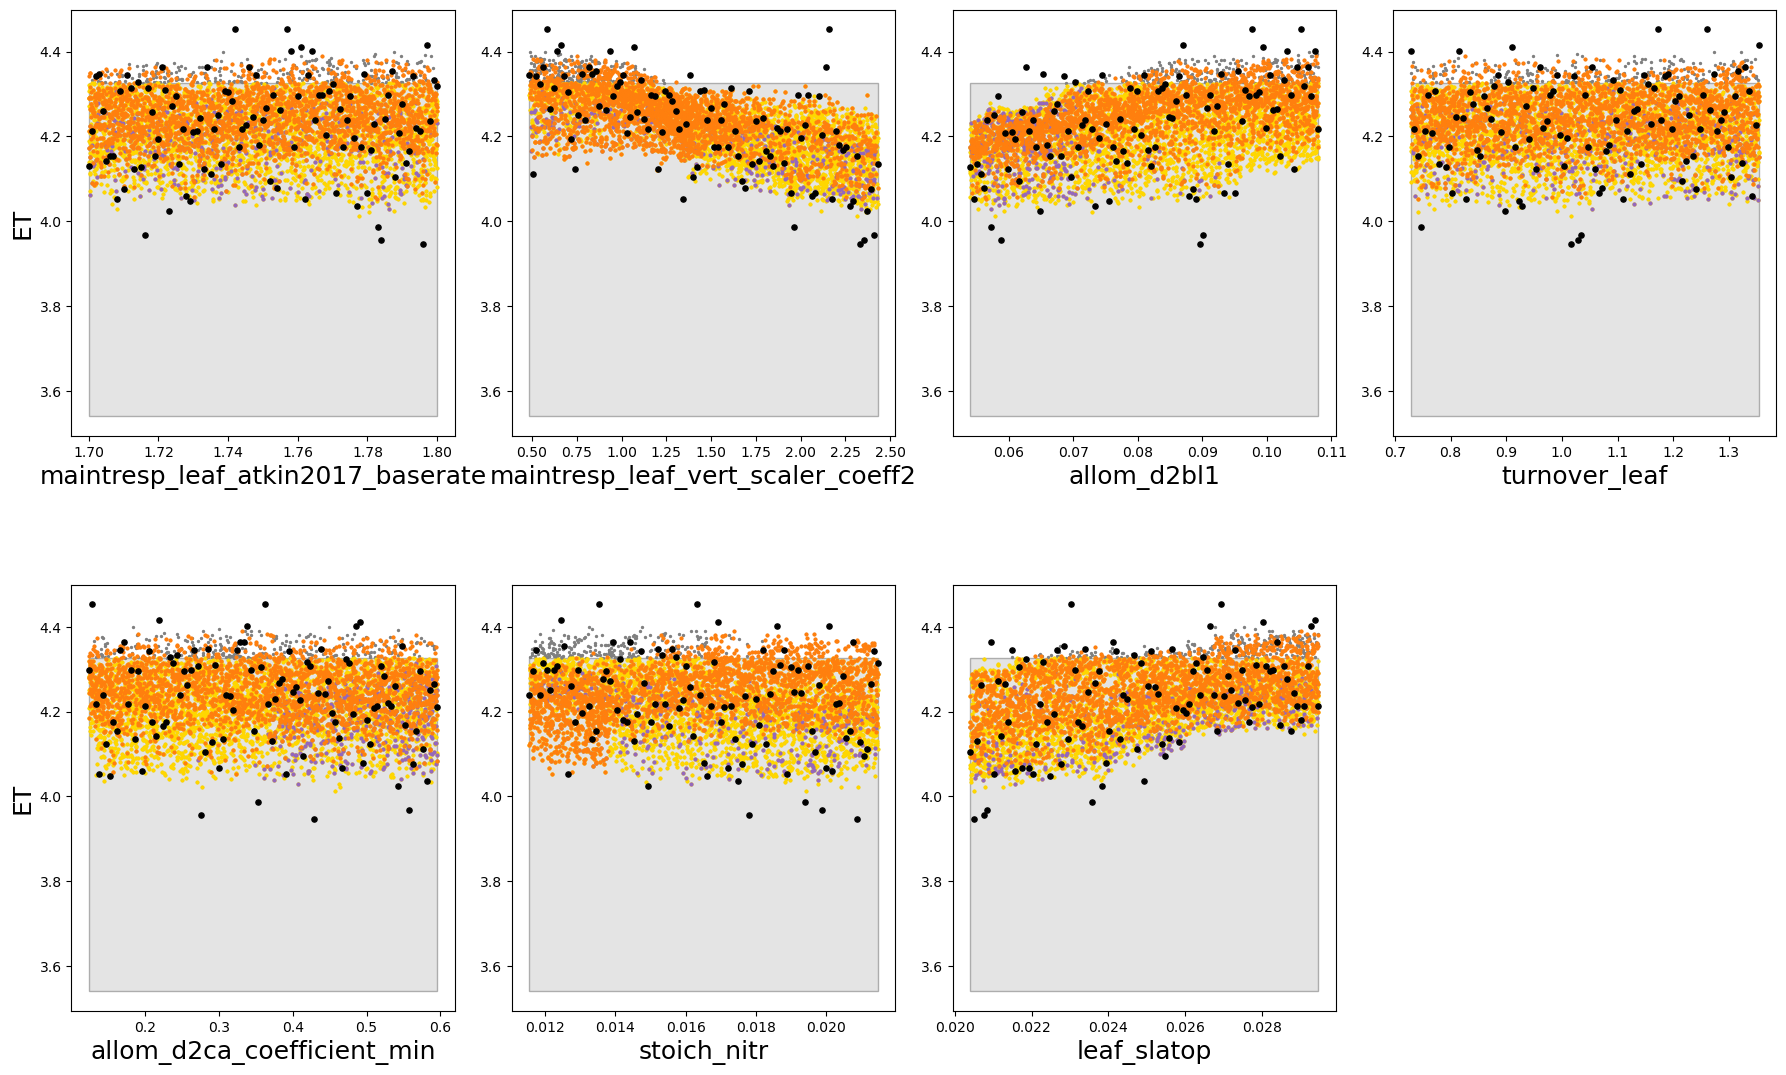

ip 0 0
vtogggle 1
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_//emulator_and_ensemble_16_GPP_p0.png


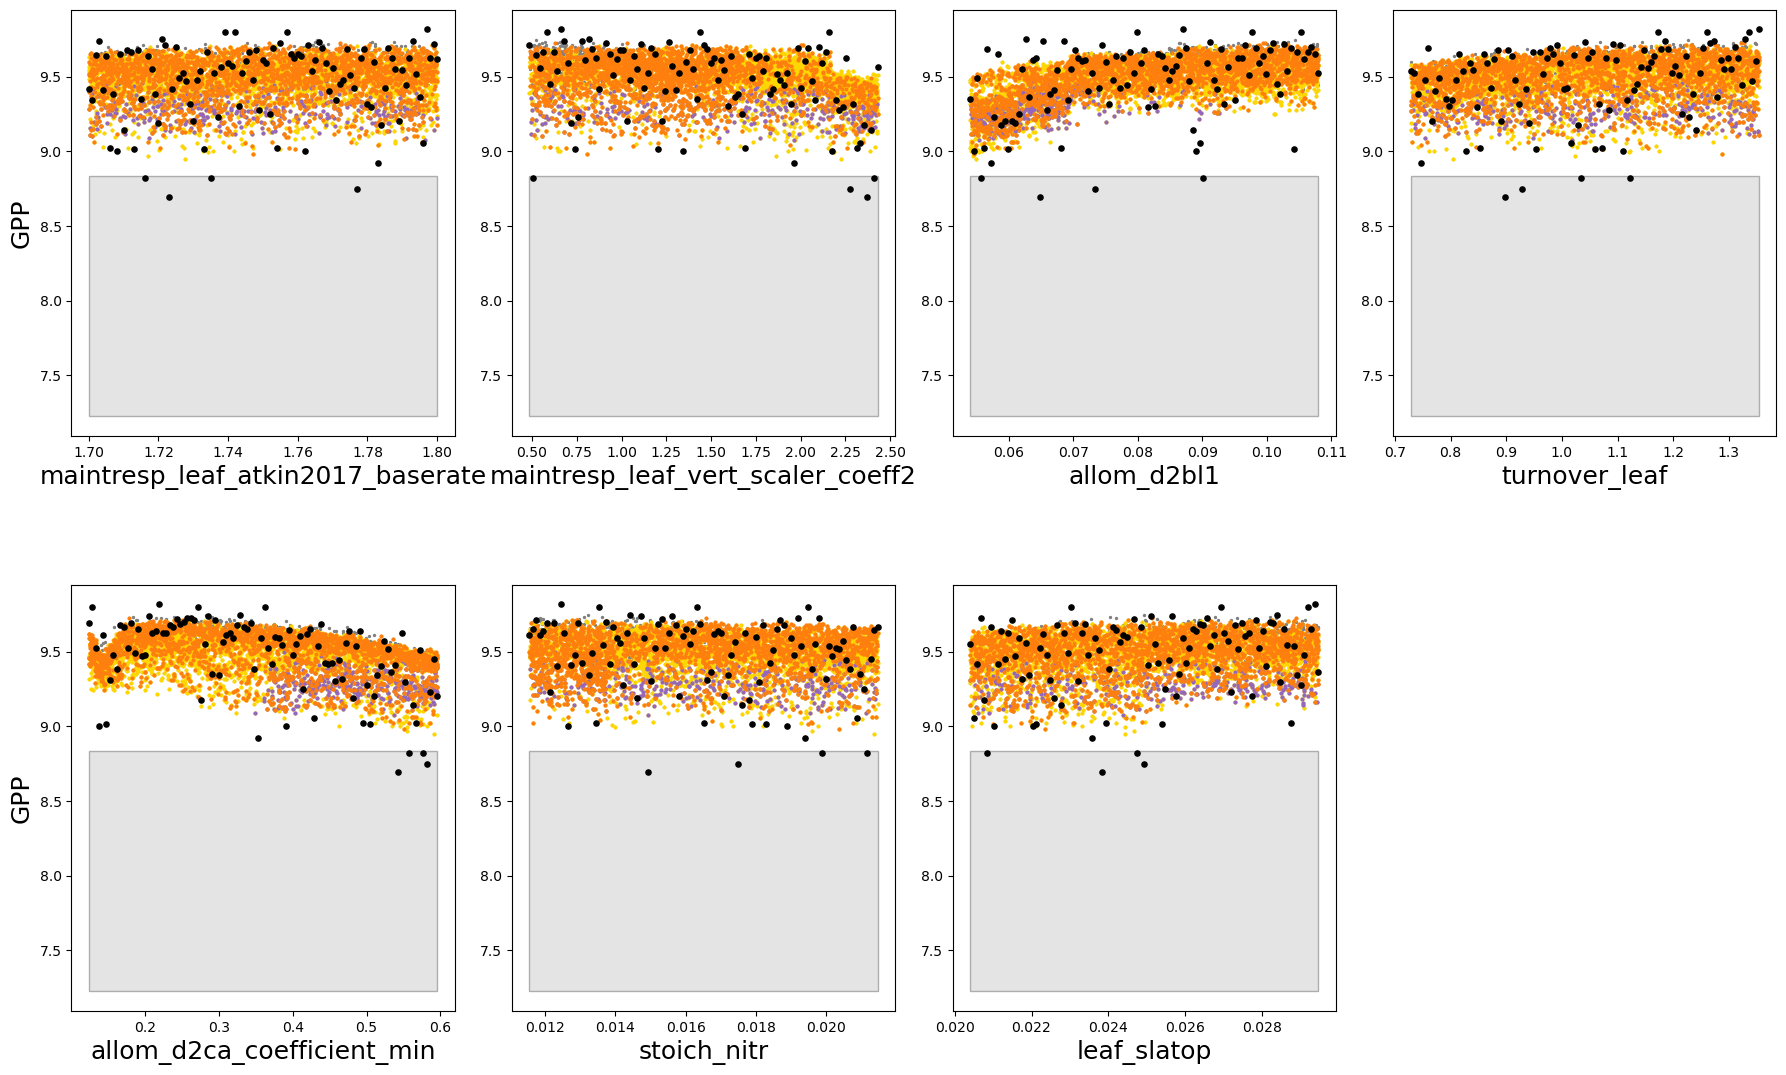

ip 0 0
vtogggle 2
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_//emulator_and_ensemble_16_LAI_p0.png


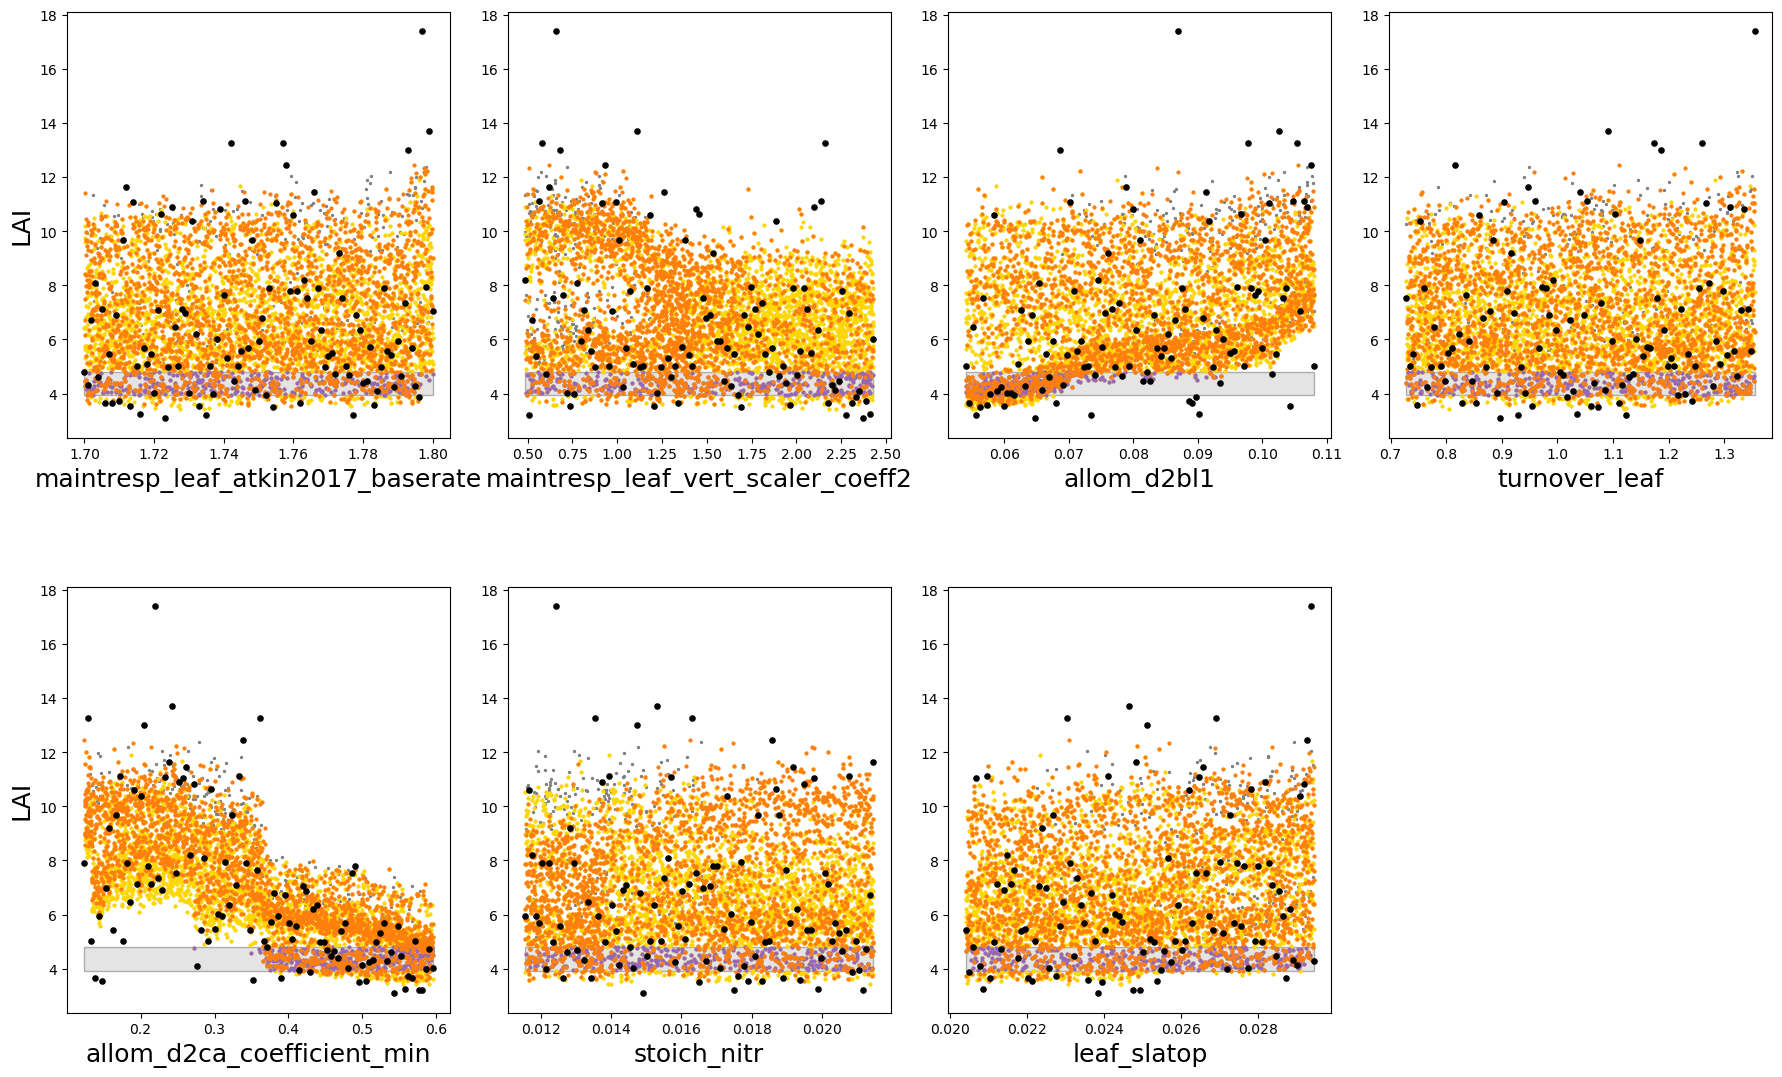

ip 0 0
vtogggle 3
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_//emulator_and_ensemble_16_CUE_p0.png


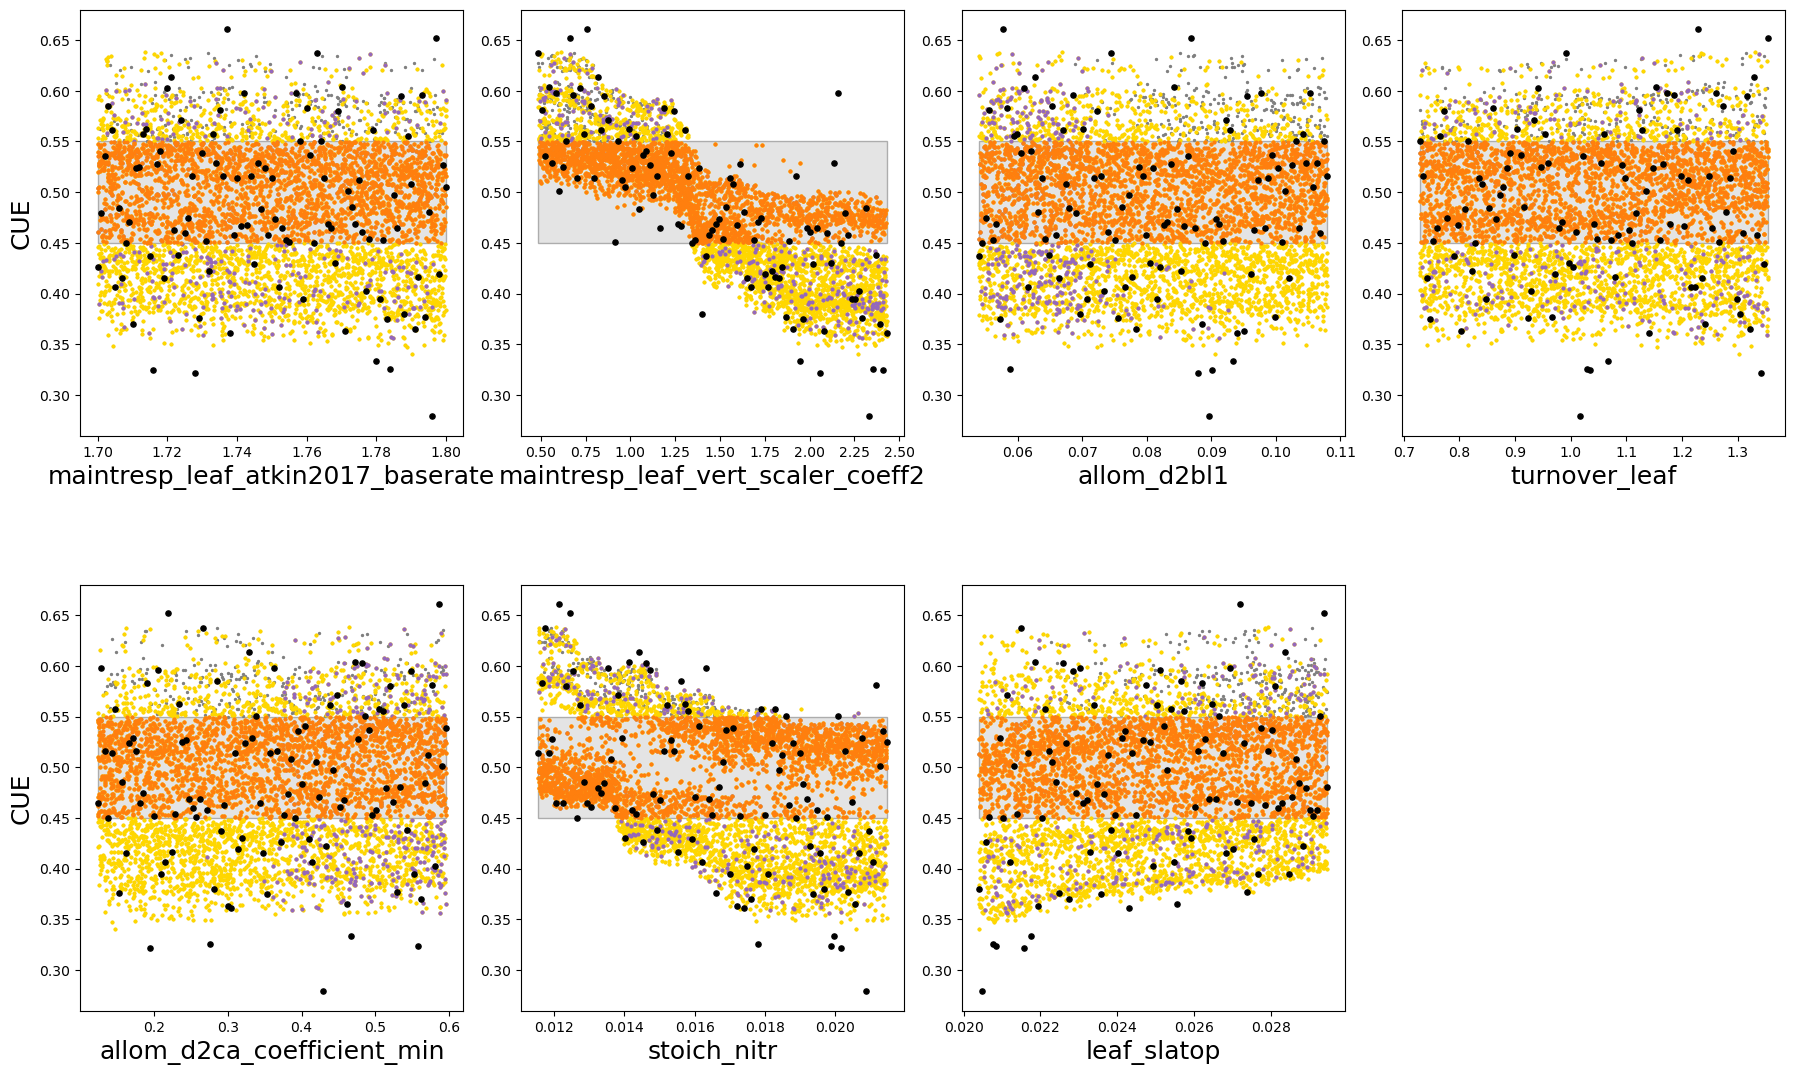

ip 0 0
vtogggle 4
/glade/u/home/rfisher/rosiefork_fates_global_cal/rosie_ppe/gaussian_emulator/figs_FATES_NOCOMP_LHC16_ALLPFTS1_e_//emulator_and_ensemble_16_VEGC_p0.png


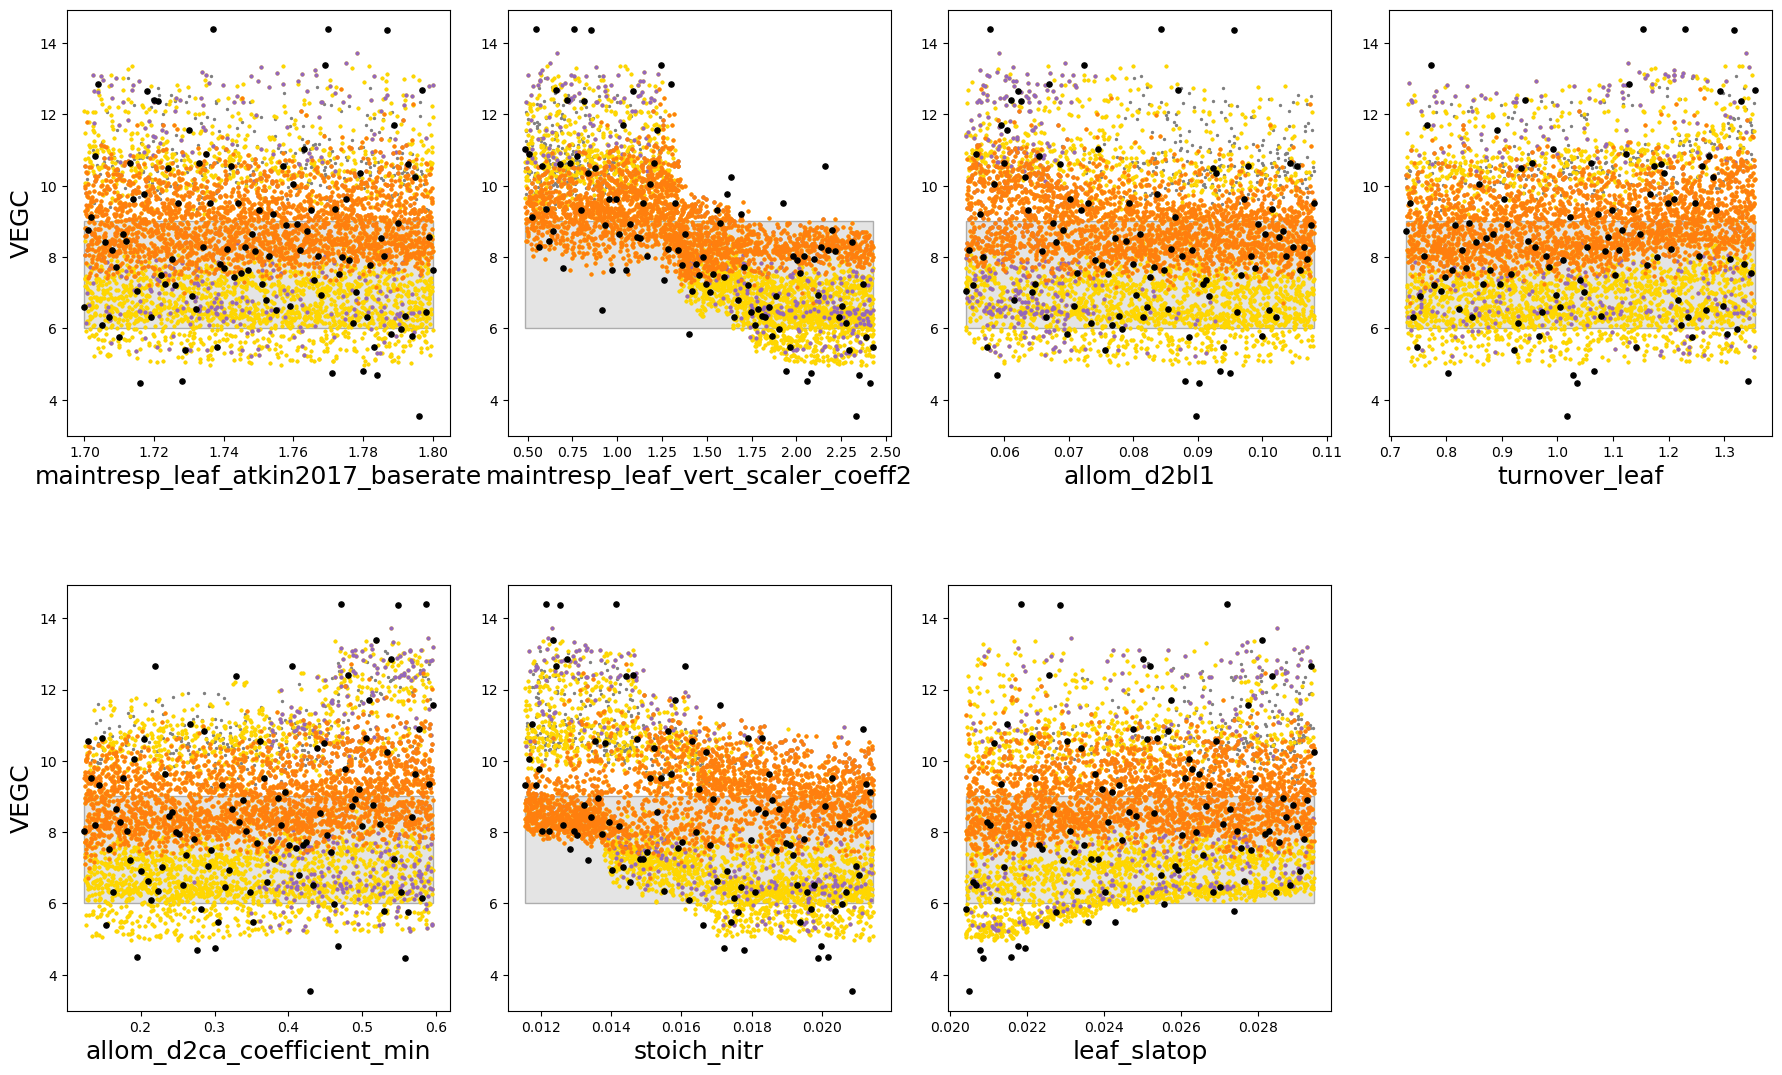

In [41]:
from matplotlib.colors import CSS4_COLORS
import matplotlib.patches as patches
colors = plt.get_cmap('tab10').colors
# Choosing a specific color from the CSS4_COLORS dictionary
chosen_color_all = CSS4_COLORS['grey']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_target = CSS4_COLORS['lightgrey']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary

chosen_color_et = CSS4_COLORS['gold']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_lai = CSS4_COLORS['forestgreen']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_ens = CSS4_COLORS['darkblue']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_gpp = CSS4_COLORS['cornflowerblue']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_cue = CSS4_COLORS['indianred']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_vegc = CSS4_COLORS['mediumblue']  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary

#chosen_color_all = colors[0]  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_cue = colors[1]   # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_lai = colors[4]   # Selecting the 'lightblue' color from the CSS4_COLORS dictionary
chosen_color_ens = colors[5]  # Selecting the 'lightblue' color from the CSS4_COLORS dictionary

#one figure for each PFT and variable combination (loops round parameters)
if pftfit==1:
    print('pfts',pfts)
    for i in range(len(pfts)):
        for vtoggle, var in enumerate(vars):
            p = pfts[i]
            #gcells=gcells_pft[p]
            print('ip',i,p)
            draw_selected_param_space(i,p,pftfit,vtoggle)   
    
            figname=figdir+'/emulator_and_ensemble_'+str(ensN)+'_'+vars_bm[vtoggle]+'_p'+str(p)+'.png'
            print(figname)
            plt.savefig(figname, bbox_inches='tight')
            plt.show() 
else:
    for i in range(len(gcells_pft[p])):
        #g=gcells[i] 
        print(g,i)
        draw_selected_param_space(g,i,pftfit)

In [42]:
y_pred_noise_vegc_pft

[array([ 9.7944658 ,  5.15464087,  8.44468199, ...,  8.18035121,
        11.18256618,  6.85657362])]

### Make function to plot 3D space

In [43]:
def plot_3d_param_space(i,g,axes, axc,v,ch):
    accept_et=accept_et_i[i]
    accept_gpp=accept_gpp_i[i] 
    if(spmode==0):
        accept_lai=accept_lai_i[i] 
        accept_cue=accept_cue_i[i] 
        
    common_values0 = (accept_et)
    common_values1 = np.intersect1d(accept_et, accept_gpp)
    if(spmode==0):    
        common_values2 = np.intersect1d(common_values1, accept_lai)
        common_values3 = np.intersect1d(common_values2, accept_cue)
    print('accept et,gpp',np.shape(accept_et),np.shape(accept_gpp))
    print('common 0,1',np.shape(common_values0),np.shape(common_values1))

    if(v==2):
        vf=0
    else:
        vf=v
    vf=1
    print(np.shape(accept_gpp),np.shape(accept_et))
    xv=feat_importance[i,0,vf]
    yv=feat_importance[i,1,vf]
    zv=feat_importance[i,2,vf]
    cv=feat_importance[i,3,vf]
    print(xv,yv,zv,cv)
    xse = Xdense[accept_et,xv]
    yse = Xdense[accept_et,yv]
    zse = Xdense[accept_et,zv]
    cse = Xdense[accept_et,cv]
    
    xsg = Xdense[accept_gpp,xv]
    ysg = Xdense[accept_gpp,yv]
    zsg = Xdense[accept_gpp,zv]
    csg = Xdense[accept_gpp,cv]

    xsc0 = Xdense[common_values0,xv]
    ysc0 = Xdense[common_values0,yv]
    zsc0 = Xdense[common_values0,zv]
    csc0 = Xdense[common_values0,cv]

    xsc1 = Xdense[common_values1,xv]
    ysc1 = Xdense[common_values1,yv]
    zsc1 = Xdense[common_values1,zv]
    csc1 = Xdense[common_values1,cv]
    
    if(spmode==0):
        xsc2 = Xdense[common_values,xv]
        ysc2 = Xdense[common_values,yv]
        zsc2 = Xdense[common_values,zv]
        csc2 = Xdense[common_values,cv]
    
        xsc3 = Xdense[common_values,xv]
        ysc3 = Xdense[common_values,yv]
        zsc3 = Xdense[common_values,zv]
        csc3 = Xdense[common_values,cv]    

    
    if(ch==1):
        xsch = Xdense[chosen_values_i[i],xv]
        ysch = Xdense[chosen_values_i[i],yv]
        zsch = Xdense[chosen_values_i[i],zv]
        csch = Xdense[chosen_values_i[i],cv]
        
    xsd = Xdense[:,xv]
    ysd = Xdense[:,yv]
    zsd = Xdense[:,zv]
    al = 1
    sz=12
    if(v==0): # ET
        plt3d=axes[axc].scatter(xsc0,  ysc0,  zsc0,s=sz, c=chosen_color_et, alpha=al,label='GPP & ET constraint')
    elif v==1: #GPP
        #plt3d=axes[axc].scatter(xsc0,  ysc0,  zsc0,s=sz+2, c=chosen_color_et, alpha=al,label=' ET constraint')
        plt3d=axes[axc].scatter(xsg,  ysg,  zsg,  s=sz,c=chosen_color_gpp, alpha=al,label='+GPP constraint')
        #plt3dl=axes[row,col].scatter(xsl,  ysl,  zsl,  s=8,c=chosen_color_lai, alpha=0.7,label='LAI constraint')
    if(spmode==0):
        if v==2:
            #plt3d=axes[axc].scatter(xsc2,  ysc2,  zsc2,  s=8,c='black', alpha=al,label='+LAI constraint')
            plt3dl=axes[row,col].scatter(xsl,  ysl,  zsl,  s=8,c=chosen_color_lai, alpha=0.7,label='LAI constraint')
        elif v==3:
            plt3d=axes[axc].scatter(xsc3,  ysc3,  zsc3,  s=8,c='black', alpha=al,label='+CUE constraint')
        #plt3dl=axes[row,col].scatter(xsl,  ysl,  zsl,  s=8,c=chosen_color_lai, alpha=0.7,label='LAI constraint')

    if(ch==1):# plot chosen values
            plt3d=axes[axc].scatter(xsch,  ysch,  zsch,  s=18,c='red', alpha=al,label='chosen points')
        
        
    fsa=14
    fst=16
    axes[axc].set_xlabel(lhc_vars_title[xv],fontsize=fsa,labelpad=12)
    axes[axc].set_ylabel(lhc_vars_title[yv],fontsize=fsa,labelpad=12)
    axes[axc].set_zlabel(lhc_vars_title[zv],fontsize=fsa)
    #axes[row,col].set_title(pftname,fontsize=fst)   

    return [plt3d]

### Plot the 3D space for each PFT average calibration

In [44]:

ncls=ncls_pft
rw=int(len(pfts)/ncls)
print(ncls,rw)
for vtoggle, var in enumerate(vars):
    fig, axes = plt.subplots(nrows=rw, ncols=ncls, figsize=(32,27),subplot_kw=dict(projection='3d'))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    if(pftfit==1):
        axcount=0
        for i in range(len(pfts)):      
            p=pfts[i] 
            print(p) 
            col = axcount % ncls 
            axc=col   
            if(rw>1):
                row = axcount //ncls
                axc=[row,col]  
  
            hnd=plot_3d_param_space(i,p, axes, axc,vtoggle,0)
            axcount=axcount+1
    leg_axis=[rw-1,ncls-1]
    if(rw>1):
        leg_axis = [  ncls-1]  
    print(leg_axis)
    #ax2D = fig.add_subplot(leg_axis)

    #legend=axes[leg_axis].legend(handles=hnd,fontsize=30)  # Place the legend in the upper right corner            
    #axes[ rw-1,ncls-1].axis('off')
    #for text in legend.get_texts():
    #    text.set_color(chosen_color)
 #   while axcount < rw*ncls:
 #       row = axcount //ncls
 #       col = axcount %ncls
 #       axes[row, col].remove()
 #       axcount += 1  
    plt.tight_layout()
    plt.savefig(figdir+'/PFT_3D_plot_e'+str(ensN)+'_'+var+'.png', bbox_inches='tight')
    plt.show()

5 0


ValueError: Number of rows must be a positive integer, not 0

<Figure size 3200x2700 with 0 Axes>

### Choose some members of the selected parameter space. 

#### Create an array of the common values

In [ ]:
import random 
noutput_files=8

chosen_values_pft =[]
for i in range(len(pfts)):
    p=pfts[i]
    accept_gpp=accept_gpp_i[i]
    accept_et=accept_et_i[i]   
    common_values_p = np.intersect1d(accept_gpp, accept_et)
    if(np.size(common_values_p) >= 10):
        random_values = random.sample(sorted(common_values_p),noutput_files)  
    else:
        random_values=[]

    print('pft,i',p,i)
    print(random_values)
    chosen_values_pft.append(random_values)
    print(np.shape(chosen_values_pft[i]))

### For each ensemble member, loop round parameters and change their values

In [ ]:
print(make_params)
make_params=1
if make_params==1:
    print(lhc_vars)
    pfile1= pfileroot+str(1)+'.nc'
    if(spmode==1):
        pout='parameter_outputs/SP_LHC_calibration_'
    else:
        pout='parameter_outputs/SP_NOCOMP_calibration_'        
    pfile1='../nocomp_parameter_modification_python/intermediate_pfiles/modified_average_file2.nc'
    
    for f in range(noutput_files):
        newfile =pout+str(ensN)+'_'+str(f)+'.nc'
        print('f',f)
        pf=xr.open_dataset(pfile1)
        for v, var in enumerate(lhc_vars):
            print('var',var)
            print((chosen_values_pft[i][:]))
            dms=pf[var].dims
            ndms=pf[var].ndim
            for i in range(len(pfts)):
                pft = pfts[i]
                print('pft var',pfts[i], var,len(chosen_values_pft[i]))
                if len(chosen_values_pft[i])>0 :
                    print('yes')

                    #print('i,pft',i,f)
                    nxd=chosen_values_pft[i][f] # for each PFT (i) and file (f)
                    varnew=Xdense[nxd,v] # Find the p1 parameter corresponding                
                    if ndms == 0: # one dimensional variable
                        print('0d var', pft,var,varnew)    
                        #pf[var][pft]=varnew
                    elif ndms==1: 
                        print(pft,varnew)
                        pf[var][pft]=varnew
                    
                    elif ndms == 2: 
                        vr=pf[var]
                        print(vr.values)
                        pf[var][0,pft]=varnew 
                else: #no fitted values, do manual tuning 
                    print('pft var',pft, var,len(chosen_values_pft[i]))
                    print('no')
                    if(pft==10 and var == 'fates_leaf_vcmax25top'):
                        pf[var][0,pft]=80                      
                    if(pft==10 and var == 'fates_leaf_stomatal_intercept'):
                        pf[var][pft]=4  
                    if(pft==11 and var == 'fates_leaf_vcmax25top'):
                        pf[var][0,pft]=20
                    if(pft==11 and var == 'fates_leaf_stomatal_intercept'):
                        pf[var][pft]=10 
                    if(pft==11 and var == 'fates_leaf_stomatal_slope_ballberry'):
                        pf[var][pft]=4    
 
                        
                    
        pf.to_netcdf(newfile)
        pf.close()


In [ ]:
#for f in range(noutput_files):
f=5

       
newfile =pout+str(ensN)+'_'+str(f)+'.nc'
pf=xr.open_dataset(newfile)

for v, var in enumerate(lhc_vars):
    print(var,pf[var].values)
pf.close()